In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
import sys
sys.path.append('../dataset')
import get_funsd


In [4]:
funsd = get_funsd.CustomFunsdDataset('../dataset/')
funsd.split_generators()

In [5]:
funsd

CustomFunsdDataset:
DatasetDict({
    train: Dataset({features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags','line_ids','linkings','image','image_name'], num_rows: 149}),
    test: Dataset({features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags','line_ids','linkings','image','image_name'], num_rows: 50})
})

In [6]:
label_map = {
    0: 'O',
    1: 'B-HEADER',
    2: 'I-HEADER',
    3: 'B-QUESTION',
    4: 'I-QUESTION',
    5: 'B-ANSWER', 
    6: 'I-ANSWER'}

In [7]:
funsd['train'][0].keys()

dict_keys(['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags', 'line_ids', 'linkings', 'image', 'image_name'])

In [8]:
from datasets import Dataset, DatasetDict

funsd_train_dataset = Dataset.from_dict({
    "id": [entry["id"] for entry in funsd["train"]],
    "tokens": [entry["tokens"] for entry in funsd["train"]],
    "ner_boxes": [entry["ner_boxes"] for entry in funsd["train"]],
    "bboxes": [entry["bboxes"] for entry in funsd["train"]],
    "ner_tags": [entry["ner_tags"] for entry in funsd["train"]],
    "line_ids": [entry["line_ids"] for entry in funsd["train"]],
    "linkings": [entry["linkings"] for entry in funsd["train"]],
    "image": [entry["image"] for entry in funsd["train"]],
    "image_name": [entry["image_name"] for entry in funsd["train"]],
})

funsd_test_dataset = Dataset.from_dict({
    "id": [entry["id"] for entry in funsd["test"]],
    "tokens": [entry["tokens"] for entry in funsd["test"]],
    "ner_boxes": [entry["ner_boxes"] for entry in funsd["test"]],
    "bboxes": [entry["bboxes"] for entry in funsd["test"]],
    "ner_tags": [entry["ner_tags"] for entry in funsd["test"]],
    "line_ids": [entry["line_ids"] for entry in funsd["test"]],
    "linkings": [entry["linkings"] for entry in funsd["test"]],
    "image": [entry["image"] for entry in funsd["test"]],
    "image_name": [entry["image_name"] for entry in funsd["test"]],
})

# Optionally, you can create a DatasetDict if you have train/test splits
dataset = DatasetDict({
    "train": funsd_train_dataset,
    'test': funsd_test_dataset
})


In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags', 'line_ids', 'linkings', 'image', 'image_name'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags', 'line_ids', 'linkings', 'image', 'image_name'],
        num_rows: 50
    })
})

In [10]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
import sys
sys.path.append('../..')
from mytools import unnormalize_box, normalize_box

In [12]:

import numpy as np
def make_dataset(documents):
    images = documents['image']
    
    rgb_images = list(map(lambda img: img.convert('RGB'), images))
  
    words = documents['tokens']
    
    boxes = documents['bboxes'] ## token boxes normalized below
    
    word_labels = documents['ner_tags']
    
    normalized_boxes = []

    # Normalize the boxes by image width and height
    for i in range(len(boxes)):
        normalized_boxes.append([])
        for j in range(len(boxes[i])):
            normalized_boxes[-1].append(normalize_box(boxes[i][j], images[i].width, images[i].height))

    encoding = processor(rgb_images, words, boxes=normalized_boxes, word_labels=word_labels,
                         truncation=True, padding="max_length", return_offsets_mapping=True)
    
    encoding.pop('offset_mapping')

    return encoding

In [13]:
cols = funsd_train_dataset.column_names



Standardization: Many popular image classification models, like AlexNet, ResNet, and Vision Transformers, originally used 224x224 as a default input size. It has since become a standard, simplifying the process of reusing pre-trained models and ensuring consistency across various tasks.

Computational Efficiency: A size of 224x224 provides a good balance between image detail and computational cost. If images were too large, the model would require significantly more memory and processing power, but if they were too small, important details could be lost. 224x224 strikes a balance where enough spatial information is preserved while keeping the model efficient.

Training and Pre-training: Many models, including LayoutLMv3, are pre-trained on large datasets like ImageNet, where images are typically resized to 224x224. To take advantage of this pre-training and transfer learning, using the same input size ensures compatibility with the pre-trained weights and architectures.

224x224 is automated by layoutlm3

Bounding boxes: Stay on a 0-1000 scale to maintain relative spatial positioning of text or entities in the document.
Images: Resized to 224x224 pixels to meet the input size requirement of the visual part of the model.

In [14]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})
train_dataset = dataset["train"].map(
    make_dataset,
    batched=True,
    remove_columns = cols,
    features=features)

Map: 100%|██████████| 149/149 [00:01<00:00, 75.65 examples/s]


In [15]:
test_dataset = dataset["test"].map(
    make_dataset,
    batched=True,
    remove_columns = cols,
    features=features)

Map: 100%|██████████| 50/50 [00:00<00:00, 78.86 examples/s]


In [16]:
print(processor.tokenizer.decode(train_dataset[0]["input_ids"]))

<s> R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity. ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip. wp</s><pad><pad><pad><pad><pad><pad><pad><pa

In [17]:
train_dataset.set_format("torch")
test_dataset.set_format("torch")

In [18]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)


pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [19]:
c=0
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())
  c+=1
  if c>10:break

<s> -100
 R 0
& -100
D -100
 : 3
 Suggest 3
ion -100
: -100
 Date 3
: -100
 License 5


In [20]:
from evaluate import load 
metric = load("seqeval") 

In [21]:
label_list = ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']

In [22]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [23]:
label_map_reversed = {v: k for k, v in label_map.items()} 


In [24]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.data.data_collator import default_data_collator
from transformers.trainer_callback import TrainerCallback
import optuna
import os
from transformers import LayoutLMv3ForTokenClassification
import json
import numpy as np



class MetricsTrackingCallback(TrainerCallback):
    def __init__(self):
        self.metrics_history = {
            'train': [],
            'eval': [],
            'epoch': []
        }
        self.current_train_metrics = None
        self.last_logged_epoch = None

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        """Called after evaluation"""
        if metrics and state.epoch != self.last_logged_epoch:
            # Store evaluation metrics
            eval_metrics = {
                'precision': metrics.get('eval_precision', None),
                'recall': metrics.get('eval_recall', None),
                'f1': metrics.get('eval_f1', None),
                'accuracy': metrics.get('eval_accuracy', None)
            }
            
            # Store training metrics that were saved during training
            train_metrics = {}
            if self.current_train_metrics is not None:
                train_metrics = self.current_train_metrics
                self.current_train_metrics = None  # Reset for next epoch
            
            # Append metrics for this epoch
            self.metrics_history['train'].append(train_metrics)
            self.metrics_history['eval'].append(eval_metrics)
            self.metrics_history['epoch'].append(state.epoch)
            self.last_logged_epoch = state.epoch
            
            # Save to file
            save_dir = args.output_dir
            os.makedirs(save_dir, exist_ok=True)
            with open(os.path.join(save_dir, 'metrics_history.json'), 'w') as f:
                json.dump(self.metrics_history, f, indent=2)

    def on_log(self, args, state, control, logs=None, **kwargs):
        """Called on each training log"""
        if logs:
            # Check if these are training metrics (not eval metrics)
            if all(not k.startswith('eval_') for k in logs.keys()):
                # Store the most recent training metrics
                self.current_train_metrics = {
                    'loss': logs.get('loss', None),
                    'learning_rate': logs.get('learning_rate', None)
                }

hyperparameter_dict = {}

def objective(trial):
    model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                             id2label=label_map,
                                                             label2id=label_map_reversed).to(device)
    
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    batch_size = 2
    
    model.config.hidden_dropout_prob = dropout
    model.config.attention_probs_dropout_prob = dropout
    
    trial_output_dir = f'./results/'
    training_args = TrainingArguments(
        output_dir=trial_output_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=200,
        weight_decay=weight_decay,
        logging_strategy="epoch",        # Log once per epoch
        logging_first_step=True,         # Log the first step
        evaluation_strategy="epoch",     # Evaluate once per epoch
        save_strategy="epoch",
        metric_for_best_model="eval_f1",
        load_best_model_at_end=True,
        save_total_limit=1
    )
    
    # Initialize callbacks
    metrics_callback = MetricsTrackingCallback()
    early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset.select(range(119)),
        eval_dataset=train_dataset.select(range(119, len(train_dataset))),
        tokenizer=processor,
        data_collator=default_data_collator,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback, metrics_callback]
    )
    
    train_result = trainer.train()
    eval_results = trainer.evaluate()
    
    # Store all metrics including per-epoch history
    hyperparameter_dict[trial.number] = {
        "final_eval_results": eval_results,
        "metrics_history": metrics_callback.metrics_history,
        "hyperparameters": {
            "dropout": dropout,
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
        }
    }
    
    return eval_results["eval_f1"]

In [25]:
# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2024-10-21 13:46:22,096] A new study created in memory with name: no-name-98ddbe1d-0de9-41be-a3a7-d9dece3434ac
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 0/12000 [00:00<?, ?it/s]c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  0%|          | 2/12000 [00:00<1:03:52,  3.13it/s]

{'loss': 1.8252, 'grad_norm': 13.041524887084961, 'learning_rate': 0.0001553399326958385, 'epoch': 0.02}


  0%|          | 60/12000 [00:11<33:21,  5.96it/s] 

{'loss': 1.7925, 'grad_norm': 2.181394338607788, 'learning_rate': 0.0001545761143752239, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                  
  0%|          | 60/12000 [00:12<33:21,  5.96it/s]

{'eval_loss': 1.831567406654358, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0641, 'eval_samples_per_second': 28.193, 'eval_steps_per_second': 14.097, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:27<32:24,  6.11it/s] 

{'loss': 1.7686, 'grad_norm': 5.209904670715332, 'learning_rate': 0.00015379934998137855, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                   
  1%|          | 120/12000 [00:28<32:24,  6.11it/s]

{'eval_loss': 1.8490816354751587, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0706, 'eval_samples_per_second': 28.022, 'eval_steps_per_second': 14.011, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:42<32:31,  6.06it/s]  

{'loss': 1.7683, 'grad_norm': 6.4642863273620605, 'learning_rate': 0.00015302258558753322, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                   
  2%|▏         | 180/12000 [00:43<32:31,  6.06it/s]

{'eval_loss': 1.8055307865142822, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0714, 'eval_samples_per_second': 28.002, 'eval_steps_per_second': 14.001, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:59<32:34,  6.02it/s]  

{'loss': 1.7693, 'grad_norm': 4.747400283813477, 'learning_rate': 0.00015224582119368786, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                   
  2%|▏         | 240/12000 [01:00<32:34,  6.02it/s]

{'eval_loss': 1.815460205078125, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0835, 'eval_samples_per_second': 27.688, 'eval_steps_per_second': 13.844, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:16<31:58,  6.10it/s]  

{'loss': 1.7521, 'grad_norm': 3.2507717609405518, 'learning_rate': 0.00015146905679984252, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                   
  2%|▎         | 300/12000 [01:17<31:58,  6.10it/s]

{'eval_loss': 1.8014525175094604, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0711, 'eval_samples_per_second': 28.008, 'eval_steps_per_second': 14.004, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:33<32:26,  5.98it/s]  

{'loss': 1.7619, 'grad_norm': 3.823894739151001, 'learning_rate': 0.00015069229240599716, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                   
  3%|▎         | 360/12000 [01:34<32:26,  5.98it/s]

{'eval_loss': 1.7983207702636719, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0783, 'eval_samples_per_second': 27.822, 'eval_steps_per_second': 13.911, 'epoch': 6.0}


  3%|▎         | 360/12000 [01:38<52:56,  3.66it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 98.1375, 'train_samples_per_second': 242.517, 'train_steps_per_second': 122.277, 'train_loss': 1.768858273824056, 'epoch': 6.0}


 93%|█████████▎| 14/15 [00:00<00:00, 15.10it/s]c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 15/15 [00:01<00:00, 14.91it/s]
[I 2024-10-21 13:48:02,726] Trial 0 finished with value: 0.0 and parameters: {'dropout': 0.17774491316388719, 'learning_rate': 0.00015535287876906924, 'weight_decay': 0.003409962771218038}. Best is trial 0 with value: 0.0.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\mye

{'loss': 1.9366, 'grad_norm': 14.25538444519043, 'learning_rate': 8.524830610692474e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:11<33:10,  6.00it/s]

{'loss': 1.1963, 'grad_norm': 14.94361686706543, 'learning_rate': 8.482913367086269e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:12<33:10,  6.00it/s]

{'eval_loss': 0.9659005403518677, 'eval_precision': 0.6141479099678456, 'eval_recall': 0.6932849364791288, 'eval_f1': 0.6513213981244672, 'eval_accuracy': 0.6784968684759917, 'eval_runtime': 1.0649, 'eval_samples_per_second': 28.171, 'eval_steps_per_second': 14.086, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:26<33:14,  5.96it/s] 

{'loss': 0.8275, 'grad_norm': 10.343790054321289, 'learning_rate': 8.440285661724026e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:27<33:14,  5.96it/s]

{'eval_loss': 0.8810945153236389, 'eval_precision': 0.5856313497822931, 'eval_recall': 0.7323049001814882, 'eval_f1': 0.6508064516129032, 'eval_accuracy': 0.6988517745302714, 'eval_runtime': 1.0777, 'eval_samples_per_second': 27.836, 'eval_steps_per_second': 13.918, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:43<32:52,  5.99it/s]  

{'loss': 0.651, 'grad_norm': 9.852193832397461, 'learning_rate': 8.397657956361784e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:44<32:52,  5.99it/s]

{'eval_loss': 0.749627411365509, 'eval_precision': 0.6647681041497152, 'eval_recall': 0.7413793103448276, 'eval_f1': 0.7009867009867009, 'eval_accuracy': 0.7685281837160751, 'eval_runtime': 1.0651, 'eval_samples_per_second': 28.167, 'eval_steps_per_second': 14.083, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [01:00<32:53,  5.96it/s]  

{'loss': 0.478, 'grad_norm': 23.156124114990234, 'learning_rate': 8.35503025099954e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [01:01<32:53,  5.96it/s]

{'eval_loss': 0.9785993695259094, 'eval_precision': 0.6551433389544689, 'eval_recall': 0.70508166969147, 'eval_f1': 0.6791958041958042, 'eval_accuracy': 0.708768267223382, 'eval_runtime': 1.0971, 'eval_samples_per_second': 27.344, 'eval_steps_per_second': 13.672, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:17<32:50,  5.94it/s]  

{'loss': 0.3815, 'grad_norm': 6.760324954986572, 'learning_rate': 8.312402545637298e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:18<32:50,  5.94it/s]

{'eval_loss': 0.7738440632820129, 'eval_precision': 0.6845140032948929, 'eval_recall': 0.7540834845735027, 'eval_f1': 0.7176165803108808, 'eval_accuracy': 0.7805323590814196, 'eval_runtime': 1.0799, 'eval_samples_per_second': 27.781, 'eval_steps_per_second': 13.89, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:34<32:34,  5.96it/s]  

{'loss': 0.2882, 'grad_norm': 5.482396125793457, 'learning_rate': 8.269774840275055e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:35<32:34,  5.96it/s]

{'eval_loss': 0.8257072567939758, 'eval_precision': 0.7249134948096886, 'eval_recall': 0.7604355716878403, 'eval_f1': 0.7422497785651019, 'eval_accuracy': 0.791231732776618, 'eval_runtime': 1.0684, 'eval_samples_per_second': 28.078, 'eval_steps_per_second': 14.039, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:51<32:17,  5.98it/s]  

{'loss': 0.2066, 'grad_norm': 5.322861671447754, 'learning_rate': 8.227147134912813e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:52<32:17,  5.98it/s]

{'eval_loss': 0.9882257580757141, 'eval_precision': 0.6718885987815492, 'eval_recall': 0.7005444646098004, 'eval_f1': 0.6859173700577521, 'eval_accuracy': 0.7596555323590815, 'eval_runtime': 1.0878, 'eval_samples_per_second': 27.578, 'eval_steps_per_second': 13.789, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [02:08<32:14,  5.96it/s]  

{'loss': 0.1869, 'grad_norm': 2.2955524921417236, 'learning_rate': 8.184519429550571e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [02:09<32:14,  5.96it/s]

{'eval_loss': 1.0372589826583862, 'eval_precision': 0.6424625098658248, 'eval_recall': 0.7386569872958257, 'eval_f1': 0.6872097931616715, 'eval_accuracy': 0.7541753653444676, 'eval_runtime': 1.0751, 'eval_samples_per_second': 27.904, 'eval_steps_per_second': 13.952, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [02:24<32:14,  5.92it/s]  

{'loss': 0.1556, 'grad_norm': 6.37592077255249, 'learning_rate': 8.141891724188328e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [02:25<32:14,  5.92it/s]

{'eval_loss': 0.97458815574646, 'eval_precision': 0.7178602243313201, 'eval_recall': 0.7549909255898367, 'eval_f1': 0.7359575409111013, 'eval_accuracy': 0.776356993736952, 'eval_runtime': 1.0651, 'eval_samples_per_second': 28.167, 'eval_steps_per_second': 14.083, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:41<32:04,  5.92it/s]  

{'loss': 0.1256, 'grad_norm': 5.565208911895752, 'learning_rate': 8.099264018826086e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:42<32:04,  5.92it/s]

{'eval_loss': 1.2032071352005005, 'eval_precision': 0.6845528455284553, 'eval_recall': 0.764065335753176, 'eval_f1': 0.7221269296740995, 'eval_accuracy': 0.7306889352818372, 'eval_runtime': 1.0652, 'eval_samples_per_second': 28.164, 'eval_steps_per_second': 14.082, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:58<31:38,  5.97it/s]  

{'loss': 0.1022, 'grad_norm': 3.3035902976989746, 'learning_rate': 8.056636313463842e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:59<31:38,  5.97it/s]

{'eval_loss': 1.400293231010437, 'eval_precision': 0.7158371040723982, 'eval_recall': 0.7177858439201452, 'eval_f1': 0.716810149524241, 'eval_accuracy': 0.752348643006263, 'eval_runtime': 1.069, 'eval_samples_per_second': 28.064, 'eval_steps_per_second': 14.032, 'epoch': 11.0}


  6%|▌         | 660/12000 [03:03<52:36,  3.59it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 183.593, 'train_samples_per_second': 129.635, 'train_steps_per_second': 65.362, 'train_loss': 0.4192687547568119, 'epoch': 11.0}


100%|██████████| 15/15 [00:01<00:00, 14.78it/s]
[I 2024-10-21 13:51:08,384] Trial 1 finished with value: 0.7422497785651019 and parameters: {'dropout': 0.13324305604101402, 'learning_rate': 8.525541072448511e-05, 'weight_decay': 2.9750033090598263e-06}. Best is trial 1 with value: 0.7422497785651019.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<43:13,  4.63it/s]

{'loss': 1.7913, 'grad_norm': 12.798332214355469, 'learning_rate': 0.00020528631522522206, 'epoch': 0.02}


  0%|          | 60/12000 [00:11<33:51,  5.88it/s]

{'loss': 1.8044, 'grad_norm': 2.1867992877960205, 'learning_rate': 0.00020427690672465633, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  0%|          | 60/12000 [00:12<33:51,  5.88it/s]

{'eval_loss': 1.83781099319458, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0777, 'eval_samples_per_second': 27.836, 'eval_steps_per_second': 13.918, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:26<33:39,  5.88it/s] 

{'loss': 1.7679, 'grad_norm': 4.943317890167236, 'learning_rate': 0.00020325038960543695, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 120/12000 [00:27<33:39,  5.88it/s]

{'eval_loss': 1.840792179107666, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0644, 'eval_samples_per_second': 28.184, 'eval_steps_per_second': 14.092, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:42<33:28,  5.89it/s]  

{'loss': 1.7671, 'grad_norm': 6.271970272064209, 'learning_rate': 0.00020222387248621757, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 180/12000 [00:43<33:28,  5.89it/s]

{'eval_loss': 1.8059229850769043, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0711, 'eval_samples_per_second': 28.009, 'eval_steps_per_second': 14.004, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:57<32:48,  5.97it/s]  

{'loss': 1.7695, 'grad_norm': 4.467825889587402, 'learning_rate': 0.0002011973553669982, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 240/12000 [00:58<32:48,  5.97it/s]

{'eval_loss': 1.8113313913345337, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0711, 'eval_samples_per_second': 28.009, 'eval_steps_per_second': 14.004, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:12<32:41,  5.96it/s]  

{'loss': 1.7509, 'grad_norm': 3.3389713764190674, 'learning_rate': 0.0002001708382477788, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▎         | 300/12000 [01:13<32:41,  5.96it/s]

{'eval_loss': 1.802996039390564, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0661, 'eval_samples_per_second': 28.14, 'eval_steps_per_second': 14.07, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:27<32:42,  5.93it/s]  

{'loss': 1.7616, 'grad_norm': 3.92231822013855, 'learning_rate': 0.00019914432112855943, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 360/12000 [01:28<32:42,  5.93it/s]

{'eval_loss': 1.7978479862213135, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0741, 'eval_samples_per_second': 27.931, 'eval_steps_per_second': 13.966, 'epoch': 6.0}


  3%|▎         | 360/12000 [01:32<49:35,  3.91it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 91.9215, 'train_samples_per_second': 258.916, 'train_steps_per_second': 130.546, 'train_loss': 1.7702096972200605, 'epoch': 6.0}


 93%|█████████▎| 14/15 [00:00<00:00, 15.34it/s]c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 15/15 [00:01<00:00, 14.84it/s]
[I 2024-10-21 13:52:42,358] Trial 2 finished with value: 0.0 and parameters: {'dropout': 0.24939704694087006, 'learning_rate': 0.0002053034238438757, 'weight_decay': 0.00013830127984202332}. Best is trial 1 with value: 0.7422497785651019.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capst

{'loss': 1.9366, 'grad_norm': 14.25538444519043, 'learning_rate': 0.0003420367021818406, 'epoch': 0.02}


  0%|          | 60/12000 [00:11<33:35,  5.93it/s]

{'loss': 1.8292, 'grad_norm': 1.7684723138809204, 'learning_rate': 0.0003403548815777295, 'epoch': 1.0}



  0%|          | 60/12000 [00:12<33:35,  5.93it/s]

{'eval_loss': 1.8346445560455322, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0774, 'eval_samples_per_second': 27.846, 'eval_steps_per_second': 13.923, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:26<33:30,  5.91it/s] 

{'loss': 1.7728, 'grad_norm': 4.420769214630127, 'learning_rate': 0.0003386445555396505, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 120/12000 [00:27<33:30,  5.91it/s]

{'eval_loss': 1.8372952938079834, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0645, 'eval_samples_per_second': 28.182, 'eval_steps_per_second': 14.091, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:41<33:06,  5.95it/s]  

{'loss': 1.7703, 'grad_norm': 5.373596668243408, 'learning_rate': 0.00033693422950157144, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 180/12000 [00:42<33:06,  5.95it/s]

{'eval_loss': 1.8050696849822998, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0814, 'eval_samples_per_second': 27.742, 'eval_steps_per_second': 13.871, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:58<33:07,  5.92it/s]  

{'loss': 1.7698, 'grad_norm': 3.968357563018799, 'learning_rate': 0.0003352239034634924, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 240/12000 [00:59<33:07,  5.92it/s]

{'eval_loss': 1.8099638223648071, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0701, 'eval_samples_per_second': 28.035, 'eval_steps_per_second': 14.018, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:14<33:09,  5.88it/s]  

{'loss': 1.7523, 'grad_norm': 2.906747817993164, 'learning_rate': 0.00033351357742541333, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▎         | 300/12000 [01:16<33:09,  5.88it/s]

{'eval_loss': 1.800939679145813, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0681, 'eval_samples_per_second': 28.087, 'eval_steps_per_second': 14.044, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:32<32:07,  6.04it/s]  

{'loss': 1.7614, 'grad_norm': 3.6398861408233643, 'learning_rate': 0.0003318032513873343, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 360/12000 [01:33<32:07,  6.04it/s]

{'eval_loss': 1.7978177070617676, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0671, 'eval_samples_per_second': 28.114, 'eval_steps_per_second': 14.057, 'epoch': 6.0}


  3%|▎         | 360/12000 [01:36<32:07,  6.04it/s]

{'train_runtime': 96.8713, 'train_samples_per_second': 245.687, 'train_steps_per_second': 123.876, 'train_loss': 1.7762655244933234, 'epoch': 6.0}


  3%|▎         | 360/12000 [01:37<52:25,  3.70it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 93%|█████████▎| 14/15 [00:00<00:00, 15.10it/s]c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 15/15 [00:01<00:00, 14.45it/s]
[I 2024-10-21 13:54:21,639] Trial 3 finished with value: 0.0 and parameters: {'dropout': 0.2732172883050924, 'learning_rate': 0.00034206520761580856, 'weight_decay': 0.000376279282555818}. Best is trial 1 with value: 0.7422497785651019.
Some weights of LayoutLMv3ForTokenClassification were not initialized

{'loss': 1.9366, 'grad_norm': 14.25538444519043, 'learning_rate': 1.8332100133347713e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:11<34:04,  5.84it/s]

{'loss': 1.2971, 'grad_norm': 11.769331932067871, 'learning_rate': 1.8241959795997305e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:12<34:04,  5.84it/s]

{'eval_loss': 0.991811215877533, 'eval_precision': 0.5887345679012346, 'eval_recall': 0.6923774954627949, 'eval_f1': 0.6363636363636364, 'eval_accuracy': 0.6565762004175365, 'eval_runtime': 1.0691, 'eval_samples_per_second': 28.061, 'eval_steps_per_second': 14.03, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:26<33:39,  5.88it/s] 

{'loss': 0.7514, 'grad_norm': 39.73692321777344, 'learning_rate': 1.815029165631893e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:27<33:39,  5.88it/s]

{'eval_loss': 0.9224318265914917, 'eval_precision': 0.6164383561643836, 'eval_recall': 0.73502722323049, 'eval_f1': 0.6705298013245033, 'eval_accuracy': 0.6899791231732777, 'eval_runtime': 1.0671, 'eval_samples_per_second': 28.114, 'eval_steps_per_second': 14.057, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:43<33:03,  5.96it/s]  

{'loss': 0.5876, 'grad_norm': 36.92586898803711, 'learning_rate': 1.805862351664055e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:44<33:03,  5.96it/s]

{'eval_loss': 0.7486060857772827, 'eval_precision': 0.6742043551088778, 'eval_recall': 0.7304900181488203, 'eval_f1': 0.7012195121951219, 'eval_accuracy': 0.7570459290187892, 'eval_runtime': 1.0759, 'eval_samples_per_second': 27.883, 'eval_steps_per_second': 13.942, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [01:00<33:08,  5.91it/s]  

{'loss': 0.463, 'grad_norm': 22.76628875732422, 'learning_rate': 1.796695537696217e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [01:01<33:08,  5.91it/s]

{'eval_loss': 0.7320194244384766, 'eval_precision': 0.670549084858569, 'eval_recall': 0.7313974591651543, 'eval_f1': 0.6996527777777778, 'eval_accuracy': 0.7661795407098121, 'eval_runtime': 1.0711, 'eval_samples_per_second': 28.008, 'eval_steps_per_second': 14.004, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:17<33:13,  5.87it/s]  

{'loss': 0.3918, 'grad_norm': 13.79021167755127, 'learning_rate': 1.787528723728379e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:18<33:13,  5.87it/s]

{'eval_loss': 0.7157208323478699, 'eval_precision': 0.6893939393939394, 'eval_recall': 0.7431941923774955, 'eval_f1': 0.7152838427947599, 'eval_accuracy': 0.7724425887265136, 'eval_runtime': 1.0802, 'eval_samples_per_second': 27.771, 'eval_steps_per_second': 13.886, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:33<32:37,  5.95it/s]  

{'loss': 0.2975, 'grad_norm': 8.11469841003418, 'learning_rate': 1.7783619097605415e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:34<32:37,  5.95it/s]

{'eval_loss': 0.7437887787818909, 'eval_precision': 0.7002518891687658, 'eval_recall': 0.7568058076225045, 'eval_f1': 0.727431312690798, 'eval_accuracy': 0.7779227557411273, 'eval_runtime': 1.0671, 'eval_samples_per_second': 28.113, 'eval_steps_per_second': 14.057, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:50<32:33,  5.93it/s]  

{'loss': 0.2418, 'grad_norm': 23.71044921875, 'learning_rate': 1.7691950957927035e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:51<32:33,  5.93it/s]

{'eval_loss': 0.7851077914237976, 'eval_precision': 0.7599660729431722, 'eval_recall': 0.8130671506352087, 'eval_f1': 0.7856203419552829, 'eval_accuracy': 0.7865344467640919, 'eval_runtime': 1.0671, 'eval_samples_per_second': 28.114, 'eval_steps_per_second': 14.057, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [02:07<32:48,  5.85it/s]  

{'loss': 0.1871, 'grad_norm': 12.513697624206543, 'learning_rate': 1.7600282818248656e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [02:08<32:48,  5.85it/s]

{'eval_loss': 0.8969135284423828, 'eval_precision': 0.7020920502092051, 'eval_recall': 0.7613430127041743, 'eval_f1': 0.7305180670439705, 'eval_accuracy': 0.7737473903966597, 'eval_runtime': 1.0621, 'eval_samples_per_second': 28.246, 'eval_steps_per_second': 14.123, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [02:23<31:57,  5.98it/s]  

{'loss': 0.1564, 'grad_norm': 1.6289641857147217, 'learning_rate': 1.7508614678570276e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [02:24<31:57,  5.98it/s]

{'eval_loss': 0.9361142516136169, 'eval_precision': 0.7513134851138353, 'eval_recall': 0.778584392014519, 'eval_f1': 0.7647058823529411, 'eval_accuracy': 0.7703549060542797, 'eval_runtime': 1.0614, 'eval_samples_per_second': 28.263, 'eval_steps_per_second': 14.132, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:40<32:04,  5.92it/s]  

{'loss': 0.148, 'grad_norm': 6.5512847900390625, 'learning_rate': 1.74169465388919e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:41<32:04,  5.92it/s]

{'eval_loss': 0.9916839599609375, 'eval_precision': 0.7669642857142858, 'eval_recall': 0.779491833030853, 'eval_f1': 0.7731773177317732, 'eval_accuracy': 0.7706158663883089, 'eval_runtime': 1.0647, 'eval_samples_per_second': 28.177, 'eval_steps_per_second': 14.088, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:57<32:27,  5.82it/s]  

{'loss': 0.1097, 'grad_norm': 13.281539916992188, 'learning_rate': 1.732527839921352e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:58<32:27,  5.82it/s]

{'eval_loss': 0.968709409236908, 'eval_precision': 0.7808098591549296, 'eval_recall': 0.8049001814882033, 'eval_f1': 0.7926720285969615, 'eval_accuracy': 0.7886221294363257, 'eval_runtime': 1.0942, 'eval_samples_per_second': 27.418, 'eval_steps_per_second': 13.709, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [03:14<31:44,  5.92it/s]  

{'loss': 0.11, 'grad_norm': 4.886656284332275, 'learning_rate': 1.723361025953514e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [03:15<31:44,  5.92it/s]

{'eval_loss': 0.996719479560852, 'eval_precision': 0.7223695844385499, 'eval_recall': 0.7413793103448276, 'eval_f1': 0.7317510076130767, 'eval_accuracy': 0.7771398747390397, 'eval_runtime': 1.0711, 'eval_samples_per_second': 28.008, 'eval_steps_per_second': 14.004, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▋         | 780/12000 [03:30<31:13,  5.99it/s]  

{'loss': 0.0878, 'grad_norm': 3.2210628986358643, 'learning_rate': 1.7141942119856766e-05, 'epoch': 13.0}



  6%|▋         | 780/12000 [03:31<31:13,  5.99it/s]

{'eval_loss': 1.0954759120941162, 'eval_precision': 0.7452006980802792, 'eval_recall': 0.7749546279491834, 'eval_f1': 0.7597864768683275, 'eval_accuracy': 0.7734864300626305, 'eval_runtime': 1.0721, 'eval_samples_per_second': 27.983, 'eval_steps_per_second': 13.991, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  7%|▋         | 840/12000 [03:47<31:29,  5.91it/s]  

{'loss': 0.0777, 'grad_norm': 9.392332077026367, 'learning_rate': 1.7050273980178386e-05, 'epoch': 14.0}



  7%|▋         | 840/12000 [03:48<31:29,  5.91it/s]

{'eval_loss': 1.094160556793213, 'eval_precision': 0.7731685789938217, 'eval_recall': 0.79491833030853, 'eval_f1': 0.7838926174496644, 'eval_accuracy': 0.7914926931106472, 'eval_runtime': 1.0632, 'eval_samples_per_second': 28.218, 'eval_steps_per_second': 14.109, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  8%|▊         | 900/12000 [04:04<31:03,  5.96it/s]  

{'loss': 0.0706, 'grad_norm': 33.77677917480469, 'learning_rate': 1.695860584050001e-05, 'epoch': 15.0}



  8%|▊         | 900/12000 [04:05<31:03,  5.96it/s]

{'eval_loss': 1.13633394241333, 'eval_precision': 0.7532355478861087, 'eval_recall': 0.7921960072595281, 'eval_f1': 0.7722246793454224, 'eval_accuracy': 0.7927974947807933, 'eval_runtime': 1.0676, 'eval_samples_per_second': 28.101, 'eval_steps_per_second': 14.051, 'epoch': 15.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  8%|▊         | 960/12000 [04:21<31:01,  5.93it/s]  

{'loss': 0.0521, 'grad_norm': 0.16454678773880005, 'learning_rate': 1.686693770082163e-05, 'epoch': 16.0}



  8%|▊         | 960/12000 [04:22<31:01,  5.93it/s]

{'eval_loss': 1.1998984813690186, 'eval_precision': 0.7322695035460993, 'eval_recall': 0.7495462794918331, 'eval_f1': 0.7408071748878925, 'eval_accuracy': 0.7781837160751566, 'eval_runtime': 1.071, 'eval_samples_per_second': 28.012, 'eval_steps_per_second': 14.006, 'epoch': 16.0}


  8%|▊         | 960/12000 [04:26<31:01,  5.93it/s]

{'train_runtime': 266.2804, 'train_samples_per_second': 89.379, 'train_steps_per_second': 45.065, 'train_loss': 0.3150168319543203, 'epoch': 16.0}


  8%|▊         | 960/12000 [04:26<51:06,  3.60it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 15/15 [00:01<00:00, 14.88it/s]
[I 2024-10-21 13:58:50,577] Trial 4 finished with value: 0.7926720285969615 and parameters: {'dropout': 0.2559901408615114, 'learning_rate': 1.8333627935675684e-05, 'weight_decay': 0.0036164377793339465}. Best is trial 4 with value: 0.7926720285969615.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `e

{'loss': 1.915, 'grad_norm': 14.731901168823242, 'learning_rate': 3.8070835989604615e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:11<33:32,  5.93it/s]

{'loss': 1.2024, 'grad_norm': 31.248620986938477, 'learning_rate': 3.788363877955489e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:12<33:32,  5.93it/s]

{'eval_loss': 0.9355738162994385, 'eval_precision': 0.5569422776911076, 'eval_recall': 0.647912885662432, 'eval_f1': 0.598993288590604, 'eval_accuracy': 0.6704070981210856, 'eval_runtime': 1.0705, 'eval_samples_per_second': 28.023, 'eval_steps_per_second': 14.012, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:26<31:37,  6.26it/s] 

{'loss': 0.7488, 'grad_norm': 21.423725128173828, 'learning_rate': 3.769326873543652e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:27<31:37,  6.26it/s]

{'eval_loss': 0.8871697783470154, 'eval_precision': 0.6007434944237918, 'eval_recall': 0.7332123411978222, 'eval_f1': 0.6604004903964037, 'eval_accuracy': 0.6985908141962421, 'eval_runtime': 1.0831, 'eval_samples_per_second': 27.698, 'eval_steps_per_second': 13.849, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:41<31:45,  6.20it/s]  

{'loss': 0.5491, 'grad_norm': 15.342649459838867, 'learning_rate': 3.7502898691318155e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:42<31:45,  6.20it/s]

{'eval_loss': 0.6774469017982483, 'eval_precision': 0.6837469975980784, 'eval_recall': 0.7749546279491834, 'eval_f1': 0.7264993619736282, 'eval_accuracy': 0.7826200417536534, 'eval_runtime': 1.051, 'eval_samples_per_second': 28.545, 'eval_steps_per_second': 14.273, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:58<31:45,  6.17it/s]  

{'loss': 0.429, 'grad_norm': 38.19307327270508, 'learning_rate': 3.7312528647199785e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:59<31:45,  6.17it/s]

{'eval_loss': 0.7728720903396606, 'eval_precision': 0.6746096959737058, 'eval_recall': 0.7450090744101633, 'eval_f1': 0.7080638206123329, 'eval_accuracy': 0.7507828810020877, 'eval_runtime': 1.0591, 'eval_samples_per_second': 28.326, 'eval_steps_per_second': 14.163, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:14<31:00,  6.29it/s]  

{'loss': 0.3192, 'grad_norm': 9.202204704284668, 'learning_rate': 3.712215860308142e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:15<31:00,  6.29it/s]

{'eval_loss': 0.7186595797538757, 'eval_precision': 0.7198275862068966, 'eval_recall': 0.7577132486388385, 'eval_f1': 0.7382847038019452, 'eval_accuracy': 0.7750521920668059, 'eval_runtime': 1.0492, 'eval_samples_per_second': 28.593, 'eval_steps_per_second': 14.297, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:29<31:04,  6.24it/s]  

{'loss': 0.2308, 'grad_norm': 7.883212089538574, 'learning_rate': 3.693178855896306e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:30<31:04,  6.24it/s]

{'eval_loss': 0.8018504977226257, 'eval_precision': 0.7115551694178974, 'eval_recall': 0.7431941923774955, 'eval_f1': 0.7270306258322238, 'eval_accuracy': 0.7685281837160751, 'eval_runtime': 1.0249, 'eval_samples_per_second': 29.272, 'eval_steps_per_second': 14.636, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:45<30:58,  6.23it/s]  

{'loss': 0.1803, 'grad_norm': 6.73207950592041, 'learning_rate': 3.674141851484469e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:46<30:58,  6.23it/s]

{'eval_loss': 0.9426310062408447, 'eval_precision': 0.765938864628821, 'eval_recall': 0.7958257713248639, 'eval_f1': 0.7805963506898086, 'eval_accuracy': 0.7881002087682673, 'eval_runtime': 1.0659, 'eval_samples_per_second': 28.145, 'eval_steps_per_second': 14.072, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [02:00<30:30,  6.29it/s]  

{'loss': 0.1577, 'grad_norm': 31.722436904907227, 'learning_rate': 3.655104847072632e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [02:01<30:30,  6.29it/s]

{'eval_loss': 1.025086522102356, 'eval_precision': 0.7580935251798561, 'eval_recall': 0.76497277676951, 'eval_f1': 0.7615176151761519, 'eval_accuracy': 0.7823590814196242, 'eval_runtime': 1.0471, 'eval_samples_per_second': 28.65, 'eval_steps_per_second': 14.325, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [02:16<30:12,  6.32it/s]  

{'loss': 0.1536, 'grad_norm': 3.5183568000793457, 'learning_rate': 3.636067842660795e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [02:17<30:12,  6.32it/s]

{'eval_loss': 0.7563378214836121, 'eval_precision': 0.7382943143812709, 'eval_recall': 0.8012704174228675, 'eval_f1': 0.7684943429068756, 'eval_accuracy': 0.7896659707724426, 'eval_runtime': 1.0421, 'eval_samples_per_second': 28.789, 'eval_steps_per_second': 14.394, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:31<29:56,  6.34it/s]  

{'loss': 0.1069, 'grad_norm': 5.236154079437256, 'learning_rate': 3.617030838248959e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:32<29:56,  6.34it/s]

{'eval_loss': 1.0544973611831665, 'eval_precision': 0.7526223776223776, 'eval_recall': 0.7813067150635209, 'eval_f1': 0.7666963490650044, 'eval_accuracy': 0.7732254697286013, 'eval_runtime': 1.0351, 'eval_samples_per_second': 28.983, 'eval_steps_per_second': 14.492, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:45<30:38,  6.17it/s]  

{'loss': 0.0908, 'grad_norm': 7.4070210456848145, 'learning_rate': 3.597993833837122e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:46<30:38,  6.17it/s]

{'eval_loss': 0.9431580901145935, 'eval_precision': 0.7322768974145121, 'eval_recall': 0.7967332123411979, 'eval_f1': 0.7631464580617124, 'eval_accuracy': 0.7972338204592901, 'eval_runtime': 1.0574, 'eval_samples_per_second': 28.371, 'eval_steps_per_second': 14.186, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [03:00<30:37,  6.14it/s]  

{'loss': 0.0887, 'grad_norm': 13.991876602172852, 'learning_rate': 3.5789568294252855e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [03:01<30:37,  6.14it/s]

{'eval_loss': 1.145469307899475, 'eval_precision': 0.7471861471861472, 'eval_recall': 0.7831215970961888, 'eval_f1': 0.764731945059814, 'eval_accuracy': 0.7771398747390397, 'eval_runtime': 1.0301, 'eval_samples_per_second': 29.124, 'eval_steps_per_second': 14.562, 'epoch': 12.0}


  6%|▌         | 720/12000 [03:05<48:23,  3.88it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 185.2629, 'train_samples_per_second': 128.466, 'train_steps_per_second': 64.773, 'train_loss': 0.3557657344473733, 'epoch': 12.0}


100%|██████████| 15/15 [00:01<00:00, 14.97it/s]
[I 2024-10-21 14:01:57,926] Trial 5 finished with value: 0.7805963506898086 and parameters: {'dropout': 0.39052061746090716, 'learning_rate': 3.807400882367325e-05, 'weight_decay': 5.883970406343132e-05}. Best is trial 4 with value: 0.7926720285969615.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<41:50,  4.78it/s]

{'loss': 2.0519, 'grad_norm': 15.161173820495605, 'learning_rate': 1.2962630412980863e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:10<31:19,  6.35it/s]

{'loss': 1.3921, 'grad_norm': 14.301259994506836, 'learning_rate': 1.2898892168596676e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:11<31:19,  6.35it/s]

{'eval_loss': 1.1612699031829834, 'eval_precision': 0.5309810671256454, 'eval_recall': 0.5598911070780399, 'eval_f1': 0.5450530035335689, 'eval_accuracy': 0.6088204592901879, 'eval_runtime': 1.0326, 'eval_samples_per_second': 29.052, 'eval_steps_per_second': 14.526, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:25<31:37,  6.26it/s] 

{'loss': 0.7996, 'grad_norm': 32.076107025146484, 'learning_rate': 1.2834073614985636e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:26<31:37,  6.26it/s]

{'eval_loss': 0.9950755834579468, 'eval_precision': 0.6350789692435578, 'eval_recall': 0.6932849364791288, 'eval_f1': 0.6629067245119306, 'eval_accuracy': 0.6805845511482255, 'eval_runtime': 1.0211, 'eval_samples_per_second': 29.38, 'eval_steps_per_second': 14.69, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:42<31:22,  6.28it/s]  

{'loss': 0.6289, 'grad_norm': 26.915193557739258, 'learning_rate': 1.2769255061374598e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:43<31:22,  6.28it/s]

{'eval_loss': 0.7598351836204529, 'eval_precision': 0.6514767932489451, 'eval_recall': 0.7005444646098004, 'eval_f1': 0.675120244862265, 'eval_accuracy': 0.7541753653444676, 'eval_runtime': 1.0761, 'eval_samples_per_second': 27.879, 'eval_steps_per_second': 13.94, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:58<31:33,  6.21it/s]  

{'loss': 0.5083, 'grad_norm': 23.87194061279297, 'learning_rate': 1.270443650776356e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:59<31:33,  6.21it/s]

{'eval_loss': 0.7028458714485168, 'eval_precision': 0.7046413502109705, 'eval_recall': 0.7577132486388385, 'eval_f1': 0.7302142544818541, 'eval_accuracy': 0.7781837160751566, 'eval_runtime': 1.0469, 'eval_samples_per_second': 28.656, 'eval_steps_per_second': 14.328, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:14<31:18,  6.23it/s]  

{'loss': 0.4198, 'grad_norm': 8.61302375793457, 'learning_rate': 1.2639617954152522e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:15<31:18,  6.23it/s]

{'eval_loss': 0.7150850892066956, 'eval_precision': 0.6705202312138728, 'eval_recall': 0.7368421052631579, 'eval_f1': 0.7021184608733246, 'eval_accuracy': 0.7674843423799582, 'eval_runtime': 1.0451, 'eval_samples_per_second': 28.705, 'eval_steps_per_second': 14.353, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:30<30:50,  6.29it/s]  

{'loss': 0.3268, 'grad_norm': 20.0846004486084, 'learning_rate': 1.2574799400541482e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:31<30:50,  6.29it/s]

{'eval_loss': 0.8099409937858582, 'eval_precision': 0.661839863713799, 'eval_recall': 0.70508166969147, 'eval_f1': 0.6827768014059754, 'eval_accuracy': 0.7643528183716075, 'eval_runtime': 1.0357, 'eval_samples_per_second': 28.966, 'eval_steps_per_second': 14.483, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:45<31:19,  6.16it/s]  

{'loss': 0.2679, 'grad_norm': 18.60398292541504, 'learning_rate': 1.2509980846930444e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:46<31:19,  6.16it/s]

{'eval_loss': 0.8301253914833069, 'eval_precision': 0.7327731092436974, 'eval_recall': 0.7912885662431942, 'eval_f1': 0.7609075043630018, 'eval_accuracy': 0.7800104384133612, 'eval_runtime': 1.0478, 'eval_samples_per_second': 28.631, 'eval_steps_per_second': 14.315, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [01:59<30:40,  6.26it/s]  

{'loss': 0.2143, 'grad_norm': 8.97951889038086, 'learning_rate': 1.2445162293319405e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [02:00<30:40,  6.26it/s]

{'eval_loss': 0.9765302538871765, 'eval_precision': 0.7052631578947368, 'eval_recall': 0.7295825771324864, 'eval_f1': 0.7172167707404103, 'eval_accuracy': 0.7708768267223383, 'eval_runtime': 1.0371, 'eval_samples_per_second': 28.926, 'eval_steps_per_second': 14.463, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [02:16<30:16,  6.31it/s]  

{'loss': 0.1858, 'grad_norm': 9.670451164245605, 'learning_rate': 1.2380343739708367e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [02:17<30:16,  6.31it/s]

{'eval_loss': 0.9035454988479614, 'eval_precision': 0.7294938917975567, 'eval_recall': 0.7586206896551724, 'eval_f1': 0.7437722419928827, 'eval_accuracy': 0.7800104384133612, 'eval_runtime': 1.0301, 'eval_samples_per_second': 29.124, 'eval_steps_per_second': 14.562, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:33<30:43,  6.18it/s]  

{'loss': 0.1588, 'grad_norm': 6.525351524353027, 'learning_rate': 1.2315525186097327e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:34<30:43,  6.18it/s]

{'eval_loss': 0.9682429432868958, 'eval_precision': 0.7306015693112468, 'eval_recall': 0.7604355716878403, 'eval_f1': 0.7452200978212539, 'eval_accuracy': 0.7834029227557411, 'eval_runtime': 1.0251, 'eval_samples_per_second': 29.266, 'eval_steps_per_second': 14.633, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:49<30:22,  6.22it/s]  

{'loss': 0.1356, 'grad_norm': 8.140111923217773, 'learning_rate': 1.2250706632486289e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:50<30:22,  6.22it/s]

{'eval_loss': 0.9731646776199341, 'eval_precision': 0.7398444252376837, 'eval_recall': 0.7767695099818511, 'eval_f1': 0.7578574590526783, 'eval_accuracy': 0.7956680584551148, 'eval_runtime': 1.0531, 'eval_samples_per_second': 28.489, 'eval_steps_per_second': 14.244, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [03:06<30:38,  6.13it/s]  

{'loss': 0.1232, 'grad_norm': 6.294556617736816, 'learning_rate': 1.218588807887525e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [03:07<30:38,  6.13it/s]

{'eval_loss': 1.1102572679519653, 'eval_precision': 0.6965394853593612, 'eval_recall': 0.7123411978221416, 'eval_f1': 0.7043517272319425, 'eval_accuracy': 0.7518267223382046, 'eval_runtime': 1.0384, 'eval_samples_per_second': 28.891, 'eval_steps_per_second': 14.446, 'epoch': 12.0}


  6%|▌         | 720/12000 [03:13<50:31,  3.72it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 193.3793, 'train_samples_per_second': 123.074, 'train_steps_per_second': 62.054, 'train_loss': 0.43101001481215157, 'epoch': 12.0}


100%|██████████| 15/15 [00:01<00:00, 14.81it/s]
[I 2024-10-21 14:05:13,446] Trial 6 finished with value: 0.7609075043630018 and parameters: {'dropout': 0.41957798269506397, 'learning_rate': 1.2963710722207714e-05, 'weight_decay': 7.597906004219617e-06}. Best is trial 4 with value: 0.7926720285969615.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<40:59,  4.88it/s]

{'loss': 2.0519, 'grad_norm': 15.161173820495605, 'learning_rate': 4.427513891267229e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:10<31:51,  6.25it/s]

{'loss': 1.1963, 'grad_norm': 16.22251319885254, 'learning_rate': 4.405743467099818e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:11<31:51,  6.25it/s]

{'eval_loss': 0.992358922958374, 'eval_precision': 0.5657894736842105, 'eval_recall': 0.6243194192377496, 'eval_f1': 0.5936151855047455, 'eval_accuracy': 0.6816283924843424, 'eval_runtime': 1.0453, 'eval_samples_per_second': 28.701, 'eval_steps_per_second': 14.35, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:25<32:07,  6.16it/s] 

{'loss': 0.7181, 'grad_norm': 24.62967872619629, 'learning_rate': 4.3836040526922806e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:26<32:07,  6.16it/s]

{'eval_loss': 0.6931959986686707, 'eval_precision': 0.6820762368207623, 'eval_recall': 0.7631578947368421, 'eval_f1': 0.7203426124197002, 'eval_accuracy': 0.7656576200417536, 'eval_runtime': 1.0304, 'eval_samples_per_second': 29.114, 'eval_steps_per_second': 14.557, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:40<31:39,  6.22it/s]  

{'loss': 0.5236, 'grad_norm': 11.04574203491211, 'learning_rate': 4.361464638284744e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:41<31:39,  6.22it/s]

{'eval_loss': 0.7519336938858032, 'eval_precision': 0.6883534136546184, 'eval_recall': 0.7776769509981851, 'eval_f1': 0.7302939923306349, 'eval_accuracy': 0.761482254697286, 'eval_runtime': 1.0387, 'eval_samples_per_second': 28.883, 'eval_steps_per_second': 14.442, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:57<31:15,  6.27it/s]  

{'loss': 0.4616, 'grad_norm': 52.38063430786133, 'learning_rate': 4.3393252238772075e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:58<31:15,  6.27it/s]

{'eval_loss': 1.0136665105819702, 'eval_precision': 0.6729048006509357, 'eval_recall': 0.7504537205081669, 'eval_f1': 0.7095667095667096, 'eval_accuracy': 0.7181628392484343, 'eval_runtime': 1.0368, 'eval_samples_per_second': 28.936, 'eval_steps_per_second': 14.468, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:13<30:37,  6.37it/s]  

{'loss': 0.3197, 'grad_norm': 5.503194808959961, 'learning_rate': 4.31718580946967e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:14<30:37,  6.37it/s]

{'eval_loss': 0.8786695003509521, 'eval_precision': 0.7548032936870998, 'eval_recall': 0.7486388384754991, 'eval_f1': 0.7517084282460137, 'eval_accuracy': 0.7753131524008351, 'eval_runtime': 1.0531, 'eval_samples_per_second': 28.487, 'eval_steps_per_second': 14.244, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:27<30:35,  6.34it/s]  

{'loss': 0.2401, 'grad_norm': 4.385586738586426, 'learning_rate': 4.2950463950621337e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:29<30:35,  6.34it/s]

{'eval_loss': 0.9377644062042236, 'eval_precision': 0.6888694127957932, 'eval_recall': 0.7132486388384754, 'eval_f1': 0.7008470798038341, 'eval_accuracy': 0.7533924843423799, 'eval_runtime': 1.0352, 'eval_samples_per_second': 28.981, 'eval_steps_per_second': 14.491, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:45<31:28,  6.13it/s]  

{'loss': 0.1879, 'grad_norm': 18.167200088500977, 'learning_rate': 4.272906980654597e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:46<31:28,  6.13it/s]

{'eval_loss': 0.8491129279136658, 'eval_precision': 0.7191383595691798, 'eval_recall': 0.7876588021778584, 'eval_f1': 0.7518406236466003, 'eval_accuracy': 0.7896659707724426, 'eval_runtime': 1.0421, 'eval_samples_per_second': 28.788, 'eval_steps_per_second': 14.394, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [02:00<31:07,  6.17it/s]  

{'loss': 0.1514, 'grad_norm': 11.216899871826172, 'learning_rate': 4.25076756624706e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [02:01<31:07,  6.17it/s]

{'eval_loss': 1.1151176691055298, 'eval_precision': 0.7223230490018149, 'eval_recall': 0.7223230490018149, 'eval_f1': 0.7223230490018149, 'eval_accuracy': 0.767223382045929, 'eval_runtime': 1.0462, 'eval_samples_per_second': 28.675, 'eval_steps_per_second': 14.337, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [02:17<30:34,  6.25it/s]  

{'loss': 0.122, 'grad_norm': 0.9323427677154541, 'learning_rate': 4.228628151839523e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [02:18<30:34,  6.25it/s]

{'eval_loss': 1.0317989587783813, 'eval_precision': 0.75736568457539, 'eval_recall': 0.7931034482758621, 'eval_f1': 0.774822695035461, 'eval_accuracy': 0.7904488517745303, 'eval_runtime': 1.045, 'eval_samples_per_second': 28.708, 'eval_steps_per_second': 14.354, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:33<27:17,  6.96it/s]  

{'loss': 0.1065, 'grad_norm': 9.098318099975586, 'learning_rate': 4.206488737431987e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:34<27:17,  6.96it/s]

{'eval_loss': 1.1546399593353271, 'eval_precision': 0.7251712328767124, 'eval_recall': 0.7686025408348457, 'eval_f1': 0.7462555066079295, 'eval_accuracy': 0.7682672233820459, 'eval_runtime': 0.8595, 'eval_samples_per_second': 34.902, 'eval_steps_per_second': 17.451, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:45<26:34,  7.11it/s]  

{'loss': 0.0959, 'grad_norm': 4.308701992034912, 'learning_rate': 4.1843493230244495e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:46<26:34,  7.11it/s]

{'eval_loss': 1.1559351682662964, 'eval_precision': 0.7048034934497817, 'eval_recall': 0.7323049001814882, 'eval_f1': 0.7182910547396529, 'eval_accuracy': 0.7693110647181628, 'eval_runtime': 0.8161, 'eval_samples_per_second': 36.761, 'eval_steps_per_second': 18.38, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [02:59<28:16,  6.65it/s]  

{'loss': 0.0652, 'grad_norm': 1.6326227188110352, 'learning_rate': 4.162209908616913e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [03:00<28:16,  6.65it/s]

{'eval_loss': 1.4020390510559082, 'eval_precision': 0.6798561151079137, 'eval_recall': 0.6860254083484574, 'eval_f1': 0.6829268292682926, 'eval_accuracy': 0.7413883089770354, 'eval_runtime': 1.0468, 'eval_samples_per_second': 28.657, 'eval_steps_per_second': 14.329, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▋         | 780/12000 [03:15<30:14,  6.18it/s]  

{'loss': 0.065, 'grad_norm': 1.0682121515274048, 'learning_rate': 4.140070494209376e-05, 'epoch': 13.0}



  6%|▋         | 780/12000 [03:16<30:14,  6.18it/s]

{'eval_loss': 1.329512119293213, 'eval_precision': 0.6823630136986302, 'eval_recall': 0.7232304900181489, 'eval_f1': 0.7022026431718063, 'eval_accuracy': 0.7638308977035491, 'eval_runtime': 1.0576, 'eval_samples_per_second': 28.366, 'eval_steps_per_second': 14.183, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  7%|▋         | 840/12000 [03:29<27:10,  6.85it/s]  

{'loss': 0.0605, 'grad_norm': 7.9906816482543945, 'learning_rate': 4.11793107980184e-05, 'epoch': 14.0}



  7%|▋         | 840/12000 [03:30<27:10,  6.85it/s]

{'eval_loss': 1.4227445125579834, 'eval_precision': 0.6818950930626058, 'eval_recall': 0.7313974591651543, 'eval_f1': 0.7057793345008756, 'eval_accuracy': 0.744258872651357, 'eval_runtime': 0.8169, 'eval_samples_per_second': 36.723, 'eval_steps_per_second': 18.362, 'epoch': 14.0}


  7%|▋         | 840/12000 [03:35<47:42,  3.90it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 215.3096, 'train_samples_per_second': 110.538, 'train_steps_per_second': 55.734, 'train_loss': 0.3091503035454523, 'epoch': 14.0}


100%|██████████| 15/15 [00:00<00:00, 18.56it/s]
[I 2024-10-21 14:08:50,663] Trial 7 finished with value: 0.774822695035461 and parameters: {'dropout': 0.15979796020009066, 'learning_rate': 4.4278828815073544e-05, 'weight_decay': 2.860953084836753e-06}. Best is trial 4 with value: 0.7926720285969615.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<31:32,  6.34it/s]

{'loss': 2.4035, 'grad_norm': 15.536474227905273, 'learning_rate': 5.5820529210626084e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:08<28:35,  6.96it/s]

{'loss': 1.2399, 'grad_norm': 12.870450019836426, 'learning_rate': 5.554605540252316e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:09<28:35,  6.96it/s]

{'eval_loss': 0.9661650061607361, 'eval_precision': 0.5807291666666666, 'eval_recall': 0.6070780399274047, 'eval_f1': 0.5936113575865127, 'eval_accuracy': 0.6586638830897703, 'eval_runtime': 0.8131, 'eval_samples_per_second': 36.897, 'eval_steps_per_second': 18.448, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:20<27:59,  7.07it/s] 

{'loss': 0.7494, 'grad_norm': 18.889446258544922, 'learning_rate': 5.5266929495977815e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:21<27:59,  7.07it/s]

{'eval_loss': 0.764923095703125, 'eval_precision': 0.6593059936908517, 'eval_recall': 0.7586206896551724, 'eval_f1': 0.7054852320675105, 'eval_accuracy': 0.7265135699373695, 'eval_runtime': 0.8166, 'eval_samples_per_second': 36.739, 'eval_steps_per_second': 18.37, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:34<27:53,  7.06it/s]  

{'loss': 0.5438, 'grad_norm': 10.5492582321167, 'learning_rate': 5.498780358943247e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:34<27:53,  7.06it/s]

{'eval_loss': 0.726059079170227, 'eval_precision': 0.6652613827993255, 'eval_recall': 0.7159709618874773, 'eval_f1': 0.6896853146853146, 'eval_accuracy': 0.781054279749478, 'eval_runtime': 0.8131, 'eval_samples_per_second': 36.896, 'eval_steps_per_second': 18.448, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:47<27:52,  7.03it/s]  

{'loss': 0.4176, 'grad_norm': 61.646018981933594, 'learning_rate': 5.4708677682887134e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:48<27:52,  7.03it/s]

{'eval_loss': 0.9018756747245789, 'eval_precision': 0.6788025889967637, 'eval_recall': 0.7613430127041743, 'eval_f1': 0.7177074422583404, 'eval_accuracy': 0.7570459290187892, 'eval_runtime': 0.8121, 'eval_samples_per_second': 36.942, 'eval_steps_per_second': 18.471, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [00:59<27:45,  7.02it/s]  

{'loss': 0.3268, 'grad_norm': 7.596606731414795, 'learning_rate': 5.442955177634179e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [00:59<27:45,  7.02it/s]

{'eval_loss': 0.6999419331550598, 'eval_precision': 0.7435233160621761, 'eval_recall': 0.7813067150635209, 'eval_f1': 0.7619469026548673, 'eval_accuracy': 0.8029749478079332, 'eval_runtime': 0.8087, 'eval_samples_per_second': 37.094, 'eval_steps_per_second': 18.547, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:12<27:11,  7.13it/s]  

{'loss': 0.2536, 'grad_norm': 8.165486335754395, 'learning_rate': 5.415042586979645e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:13<27:11,  7.13it/s]

{'eval_loss': 0.7529047131538391, 'eval_precision': 0.7642348754448398, 'eval_recall': 0.779491833030853, 'eval_f1': 0.7717879604672058, 'eval_accuracy': 0.8131524008350731, 'eval_runtime': 0.8381, 'eval_samples_per_second': 35.795, 'eval_steps_per_second': 17.898, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:26<27:08,  7.11it/s]  

{'loss': 0.1771, 'grad_norm': 8.413321495056152, 'learning_rate': 5.38712999632511e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:27<27:08,  7.11it/s]

{'eval_loss': 0.8534070253372192, 'eval_precision': 0.7230125523012553, 'eval_recall': 0.7840290381125227, 'eval_f1': 0.7522855898998695, 'eval_accuracy': 0.7901878914405011, 'eval_runtime': 0.8147, 'eval_samples_per_second': 36.824, 'eval_steps_per_second': 18.412, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [01:40<27:09,  7.07it/s]  

{'loss': 0.142, 'grad_norm': 26.44087791442871, 'learning_rate': 5.359217405670576e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [01:41<27:09,  7.07it/s]

{'eval_loss': 0.9483356475830078, 'eval_precision': 0.7228163992869875, 'eval_recall': 0.735934664246824, 'eval_f1': 0.7293165467625898, 'eval_accuracy': 0.7980167014613778, 'eval_runtime': 0.8061, 'eval_samples_per_second': 37.218, 'eval_steps_per_second': 18.609, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [01:52<26:41,  7.15it/s]  

{'loss': 0.1157, 'grad_norm': 6.092947483062744, 'learning_rate': 5.3313048150160416e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [01:52<26:41,  7.15it/s]

{'eval_loss': 1.1032319068908691, 'eval_precision': 0.720353982300885, 'eval_recall': 0.7386569872958257, 'eval_f1': 0.7293906810035844, 'eval_accuracy': 0.7823590814196242, 'eval_runtime': 0.816, 'eval_samples_per_second': 36.763, 'eval_steps_per_second': 18.381, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:03<26:43,  7.11it/s]  

{'loss': 0.1023, 'grad_norm': 2.828599691390991, 'learning_rate': 5.303392224361507e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:04<26:43,  7.11it/s]

{'eval_loss': 1.2500417232513428, 'eval_precision': 0.7036395147313691, 'eval_recall': 0.7368421052631579, 'eval_f1': 0.7198581560283687, 'eval_accuracy': 0.7703549060542797, 'eval_runtime': 0.8111, 'eval_samples_per_second': 36.989, 'eval_steps_per_second': 18.494, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:15<26:37,  7.10it/s]  

{'loss': 0.0854, 'grad_norm': 5.654453277587891, 'learning_rate': 5.2754796337069735e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:16<26:37,  7.10it/s]

{'eval_loss': 1.0236693620681763, 'eval_precision': 0.7237185056472633, 'eval_recall': 0.7558983666061706, 'eval_f1': 0.7394584997780735, 'eval_accuracy': 0.7834029227557411, 'eval_runtime': 0.818, 'eval_samples_per_second': 36.677, 'eval_steps_per_second': 18.338, 'epoch': 11.0}


  6%|▌         | 660/12000 [02:19<39:53,  4.74it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 139.1982, 'train_samples_per_second': 170.979, 'train_steps_per_second': 86.208, 'train_loss': 0.3793648120128747, 'epoch': 11.0}


100%|██████████| 15/15 [00:00<00:00, 19.81it/s]
[I 2024-10-21 14:11:11,582] Trial 8 finished with value: 0.7717879604672058 and parameters: {'dropout': 0.3092905540955515, 'learning_rate': 5.58251813090685e-05, 'weight_decay': 0.005132358206820182}. Best is trial 4 with value: 0.7926720285969615.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<31:37,  6.32it/s]

{'loss': 1.7913, 'grad_norm': 12.798332214355469, 'learning_rate': 1.107062232732768e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:08<28:06,  7.08it/s]

{'loss': 1.459, 'grad_norm': 16.265575408935547, 'learning_rate': 1.101618723129365e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:09<28:06,  7.08it/s]

{'eval_loss': 1.2708799839019775, 'eval_precision': 0.3979094076655052, 'eval_recall': 0.5181488203266787, 'eval_f1': 0.4501379582183681, 'eval_accuracy': 0.5715031315240083, 'eval_runtime': 0.807, 'eval_samples_per_second': 37.174, 'eval_steps_per_second': 18.587, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:20<28:01,  7.06it/s] 

{'loss': 0.8986, 'grad_norm': 35.50381851196289, 'learning_rate': 1.096082950651328e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:21<28:01,  7.06it/s]

{'eval_loss': 1.1389905214309692, 'eval_precision': 0.5660051768766178, 'eval_recall': 0.5952813067150635, 'eval_f1': 0.5802742149491374, 'eval_accuracy': 0.6443110647181628, 'eval_runtime': 0.8116, 'eval_samples_per_second': 36.966, 'eval_steps_per_second': 18.483, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:32<27:53,  7.06it/s]  

{'loss': 0.7056, 'grad_norm': 11.625680923461914, 'learning_rate': 1.090547178173291e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:32<27:53,  7.06it/s]

{'eval_loss': 0.8339620232582092, 'eval_precision': 0.6261224489795918, 'eval_recall': 0.6960072595281307, 'eval_f1': 0.659217877094972, 'eval_accuracy': 0.7411273486430062, 'eval_runtime': 0.8241, 'eval_samples_per_second': 36.402, 'eval_steps_per_second': 18.201, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:43<27:51,  7.04it/s]  

{'loss': 0.5666, 'grad_norm': 30.01715087890625, 'learning_rate': 1.085011405695254e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:44<27:51,  7.04it/s]

{'eval_loss': 0.8518819212913513, 'eval_precision': 0.6400665004156276, 'eval_recall': 0.6987295825771325, 'eval_f1': 0.6681127982646421, 'eval_accuracy': 0.7361691022964509, 'eval_runtime': 0.836, 'eval_samples_per_second': 35.886, 'eval_steps_per_second': 17.943, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [00:58<27:24,  7.11it/s]  

{'loss': 0.4696, 'grad_norm': 19.728212356567383, 'learning_rate': 1.079475633217217e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [00:59<27:24,  7.11it/s]

{'eval_loss': 0.837938129901886, 'eval_precision': 0.6477935054121565, 'eval_recall': 0.705989110707804, 'eval_f1': 0.6756404689535388, 'eval_accuracy': 0.7450417536534447, 'eval_runtime': 0.8201, 'eval_samples_per_second': 36.581, 'eval_steps_per_second': 18.29, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:12<27:21,  7.09it/s]  

{'loss': 0.3833, 'grad_norm': 11.558374404907227, 'learning_rate': 1.0739398607391799e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:12<27:21,  7.09it/s]

{'eval_loss': 0.7449588775634766, 'eval_precision': 0.6393841166936791, 'eval_recall': 0.7159709618874773, 'eval_f1': 0.675513698630137, 'eval_accuracy': 0.7643528183716075, 'eval_runtime': 0.8117, 'eval_samples_per_second': 36.962, 'eval_steps_per_second': 18.481, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:25<27:25,  7.04it/s]  

{'loss': 0.3155, 'grad_norm': 32.64012908935547, 'learning_rate': 1.0684040882611429e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:26<27:25,  7.04it/s]

{'eval_loss': 0.9681841731071472, 'eval_precision': 0.6722173531989483, 'eval_recall': 0.6960072595281307, 'eval_f1': 0.6839054837271511, 'eval_accuracy': 0.7348643006263048, 'eval_runtime': 0.8091, 'eval_samples_per_second': 37.079, 'eval_steps_per_second': 18.539, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [01:39<27:29,  6.98it/s]  

{'loss': 0.2635, 'grad_norm': 26.45779800415039, 'learning_rate': 1.062868315783106e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [01:40<27:29,  6.98it/s]

{'eval_loss': 0.7807376980781555, 'eval_precision': 0.7094307561597282, 'eval_recall': 0.7577132486388385, 'eval_f1': 0.7327775340061431, 'eval_accuracy': 0.7768789144050104, 'eval_runtime': 0.8224, 'eval_samples_per_second': 36.477, 'eval_steps_per_second': 18.239, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [01:53<26:43,  7.15it/s]  

{'loss': 0.2212, 'grad_norm': 1.6497870683670044, 'learning_rate': 1.057332543305069e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [01:54<26:43,  7.15it/s]

{'eval_loss': 0.874688446521759, 'eval_precision': 0.7047451669595782, 'eval_recall': 0.7277676950998185, 'eval_f1': 0.7160714285714287, 'eval_accuracy': 0.7737473903966597, 'eval_runtime': 0.819, 'eval_samples_per_second': 36.63, 'eval_steps_per_second': 18.315, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:07<26:57,  7.05it/s]  

{'loss': 0.2008, 'grad_norm': 7.198448657989502, 'learning_rate': 1.0517967708270319e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:08<26:57,  7.05it/s]

{'eval_loss': 0.8955771923065186, 'eval_precision': 0.7052270779777207, 'eval_recall': 0.7468239564428312, 'eval_f1': 0.7254297047157338, 'eval_accuracy': 0.7513048016701461, 'eval_runtime': 0.8368, 'eval_samples_per_second': 35.852, 'eval_steps_per_second': 17.926, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:21<26:35,  7.11it/s]  

{'loss': 0.178, 'grad_norm': 18.735658645629883, 'learning_rate': 1.0462609983489948e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:22<26:35,  7.11it/s]

{'eval_loss': 0.9434019923210144, 'eval_precision': 0.7081174438687392, 'eval_recall': 0.7441016333938294, 'eval_f1': 0.7256637168141592, 'eval_accuracy': 0.7687891440501043, 'eval_runtime': 0.8252, 'eval_samples_per_second': 36.356, 'eval_steps_per_second': 18.178, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [02:34<26:28,  7.10it/s]  

{'loss': 0.1618, 'grad_norm': 12.67375373840332, 'learning_rate': 1.0407252258709578e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [02:35<26:28,  7.10it/s]

{'eval_loss': 1.0740729570388794, 'eval_precision': 0.6870689655172414, 'eval_recall': 0.7232304900181489, 'eval_f1': 0.704686118479222, 'eval_accuracy': 0.7541753653444676, 'eval_runtime': 0.8261, 'eval_samples_per_second': 36.316, 'eval_steps_per_second': 18.158, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▋         | 780/12000 [02:47<26:24,  7.08it/s]  

{'loss': 0.1322, 'grad_norm': 4.670242786407471, 'learning_rate': 1.0351894533929209e-05, 'epoch': 13.0}



  6%|▋         | 780/12000 [02:48<26:24,  7.08it/s]

{'eval_loss': 0.977359414100647, 'eval_precision': 0.6616915422885572, 'eval_recall': 0.7241379310344828, 'eval_f1': 0.6915077989601386, 'eval_accuracy': 0.7664405010438413, 'eval_runtime': 0.8295, 'eval_samples_per_second': 36.167, 'eval_steps_per_second': 18.083, 'epoch': 13.0}


  6%|▋         | 780/12000 [02:54<41:45,  4.48it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 174.0689, 'train_samples_per_second': 136.727, 'train_steps_per_second': 68.938, 'train_loss': 0.45854923877960596, 'epoch': 13.0}


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]
[I 2024-10-21 14:14:07,555] Trial 9 finished with value: 0.7327775340061431 and parameters: {'dropout': 0.1900349853360467, 'learning_rate': 1.107154495607402e-05, 'weight_decay': 0.008398096626876402}. Best is trial 4 with value: 0.7926720285969615.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<30:56,  6.46it/s]

{'loss': 2.1601, 'grad_norm': 15.497138977050781, 'learning_rate': 2.32866075378292e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:08<27:59,  7.11it/s]

{'loss': 1.3107, 'grad_norm': 9.376334190368652, 'learning_rate': 2.317210550893246e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:09<27:59,  7.11it/s]

{'eval_loss': 1.0317031145095825, 'eval_precision': 0.5738362760834671, 'eval_recall': 0.6488203266787659, 'eval_f1': 0.6090289608177172, 'eval_accuracy': 0.642223382045929, 'eval_runtime': 0.8071, 'eval_samples_per_second': 37.168, 'eval_steps_per_second': 18.584, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:20<27:46,  7.13it/s] 

{'loss': 0.7761, 'grad_norm': 21.616539001464844, 'learning_rate': 2.3055662767681545e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:20<27:46,  7.13it/s]

{'eval_loss': 0.9039033651351929, 'eval_precision': 0.6104783599088838, 'eval_recall': 0.7295825771324864, 'eval_f1': 0.6647374948325755, 'eval_accuracy': 0.6884133611691023, 'eval_runtime': 0.8148, 'eval_samples_per_second': 36.818, 'eval_steps_per_second': 18.409, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:33<27:54,  7.06it/s]  

{'loss': 0.5939, 'grad_norm': 23.86937713623047, 'learning_rate': 2.2939220026430627e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:34<27:54,  7.06it/s]

{'eval_loss': 0.6806479096412659, 'eval_precision': 0.6889438943894389, 'eval_recall': 0.7577132486388385, 'eval_f1': 0.721694036300778, 'eval_accuracy': 0.7847077244258872, 'eval_runtime': 0.8235, 'eval_samples_per_second': 36.431, 'eval_steps_per_second': 18.215, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:46<28:09,  6.96it/s]  

{'loss': 0.4557, 'grad_norm': 37.17644500732422, 'learning_rate': 2.282277728517971e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:47<28:09,  6.96it/s]

{'eval_loss': 0.83669114112854, 'eval_precision': 0.681184668989547, 'eval_recall': 0.7096188747731398, 'eval_f1': 0.695111111111111, 'eval_accuracy': 0.7460855949895616, 'eval_runtime': 0.8132, 'eval_samples_per_second': 36.893, 'eval_steps_per_second': 18.447, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:00<27:43,  7.03it/s]  

{'loss': 0.3745, 'grad_norm': 5.87687873840332, 'learning_rate': 2.2706334543928793e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:01<27:43,  7.03it/s]

{'eval_loss': 0.7203280329704285, 'eval_precision': 0.6932668329177057, 'eval_recall': 0.7568058076225045, 'eval_f1': 0.723644251626898, 'eval_accuracy': 0.7620041753653445, 'eval_runtime': 0.8051, 'eval_samples_per_second': 37.264, 'eval_steps_per_second': 18.632, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:11<27:42,  7.00it/s]  

{'loss': 0.2879, 'grad_norm': 8.223296165466309, 'learning_rate': 2.2589891802677878e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:12<27:42,  7.00it/s]

{'eval_loss': 0.7420974373817444, 'eval_precision': 0.678513731825525, 'eval_recall': 0.7622504537205081, 'eval_f1': 0.7179487179487178, 'eval_accuracy': 0.7606993736951984, 'eval_runtime': 0.8161, 'eval_samples_per_second': 36.761, 'eval_steps_per_second': 18.381, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:25<27:01,  7.14it/s]  

{'loss': 0.2298, 'grad_norm': 10.352109909057617, 'learning_rate': 2.247344906142696e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:26<27:01,  7.14it/s]

{'eval_loss': 1.0148805379867554, 'eval_precision': 0.7201062887511072, 'eval_recall': 0.7377495462794919, 'eval_f1': 0.7288211564320932, 'eval_accuracy': 0.7513048016701461, 'eval_runtime': 0.8131, 'eval_samples_per_second': 36.898, 'eval_steps_per_second': 18.449, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [01:37<27:19,  7.03it/s]  

{'loss': 0.1687, 'grad_norm': 10.668598175048828, 'learning_rate': 2.235700632017604e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [01:38<27:19,  7.03it/s]

{'eval_loss': 0.8963925242424011, 'eval_precision': 0.7337180544105524, 'eval_recall': 0.8076225045372051, 'eval_f1': 0.7688984881209503, 'eval_accuracy': 0.7823590814196242, 'eval_runtime': 0.8181, 'eval_samples_per_second': 36.672, 'eval_steps_per_second': 18.336, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [01:50<26:46,  7.13it/s]  

{'loss': 0.1339, 'grad_norm': 6.081571578979492, 'learning_rate': 2.2240563578925126e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [01:51<26:46,  7.13it/s]

{'eval_loss': 1.025648832321167, 'eval_precision': 0.7388646288209607, 'eval_recall': 0.7676950998185118, 'eval_f1': 0.753004005340454, 'eval_accuracy': 0.774008350730689, 'eval_runtime': 0.8209, 'eval_samples_per_second': 36.547, 'eval_steps_per_second': 18.273, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:04<26:32,  7.16it/s]  

{'loss': 0.1115, 'grad_norm': 3.6497249603271484, 'learning_rate': 2.2124120837674207e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:04<26:32,  7.16it/s]

{'eval_loss': 1.1210461854934692, 'eval_precision': 0.7192832764505119, 'eval_recall': 0.76497277676951, 'eval_f1': 0.741424802110818, 'eval_accuracy': 0.7531315240083507, 'eval_runtime': 0.8171, 'eval_samples_per_second': 36.716, 'eval_steps_per_second': 18.358, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:17<26:34,  7.11it/s]  

{'loss': 0.0968, 'grad_norm': 5.8923563957214355, 'learning_rate': 2.2007678096423292e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:18<26:34,  7.11it/s]

{'eval_loss': 0.9545575976371765, 'eval_precision': 0.7558724832214765, 'eval_recall': 0.8176043557168784, 'eval_f1': 0.7855274629468177, 'eval_accuracy': 0.8032359081419624, 'eval_runtime': 0.8157, 'eval_samples_per_second': 36.777, 'eval_steps_per_second': 18.388, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [02:31<26:41,  7.04it/s]  

{'loss': 0.0877, 'grad_norm': 8.39106559753418, 'learning_rate': 2.1891235355172374e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [02:32<26:41,  7.04it/s]

{'eval_loss': 1.1668658256530762, 'eval_precision': 0.7356521739130435, 'eval_recall': 0.7676950998185118, 'eval_f1': 0.7513321492007105, 'eval_accuracy': 0.7651356993736952, 'eval_runtime': 0.813, 'eval_samples_per_second': 36.9, 'eval_steps_per_second': 18.45, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▋         | 780/12000 [02:44<26:29,  7.06it/s]  

{'loss': 0.0682, 'grad_norm': 8.039302825927734, 'learning_rate': 2.177479261392146e-05, 'epoch': 13.0}



  6%|▋         | 780/12000 [02:45<26:29,  7.06it/s]

{'eval_loss': 1.000421404838562, 'eval_precision': 0.7236514522821577, 'eval_recall': 0.7912885662431942, 'eval_f1': 0.7559601213697443, 'eval_accuracy': 0.7933194154488518, 'eval_runtime': 0.8131, 'eval_samples_per_second': 36.897, 'eval_steps_per_second': 18.448, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  7%|▋         | 840/12000 [02:58<26:20,  7.06it/s]  

{'loss': 0.0584, 'grad_norm': 18.205352783203125, 'learning_rate': 2.1658349872670544e-05, 'epoch': 14.0}



  7%|▋         | 840/12000 [02:59<26:20,  7.06it/s]

{'eval_loss': 1.1990678310394287, 'eval_precision': 0.75, 'eval_recall': 0.7676950998185118, 'eval_f1': 0.758744394618834, 'eval_accuracy': 0.7899269311064718, 'eval_runtime': 0.8077, 'eval_samples_per_second': 37.142, 'eval_steps_per_second': 18.571, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  8%|▊         | 900/12000 [03:12<26:17,  7.04it/s]  

{'loss': 0.0503, 'grad_norm': 7.990165710449219, 'learning_rate': 2.1541907131419625e-05, 'epoch': 15.0}



  8%|▊         | 900/12000 [03:12<26:17,  7.04it/s]

{'eval_loss': 1.2862368822097778, 'eval_precision': 0.7563764291996482, 'eval_recall': 0.7803992740471869, 'eval_f1': 0.7682000893255918, 'eval_accuracy': 0.7792275574112735, 'eval_runtime': 0.8151, 'eval_samples_per_second': 36.806, 'eval_steps_per_second': 18.403, 'epoch': 15.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  8%|▊         | 960/12000 [03:25<25:56,  7.09it/s]  

{'loss': 0.0541, 'grad_norm': 1.9732059240341187, 'learning_rate': 2.142546439016871e-05, 'epoch': 16.0}



  8%|▊         | 960/12000 [03:26<25:56,  7.09it/s]

{'eval_loss': 1.371295690536499, 'eval_precision': 0.7745614035087719, 'eval_recall': 0.8012704174228675, 'eval_f1': 0.7876895628902765, 'eval_accuracy': 0.787839248434238, 'eval_runtime': 0.8081, 'eval_samples_per_second': 37.124, 'eval_steps_per_second': 18.562, 'epoch': 16.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  8%|▊         | 1020/12000 [03:39<25:32,  7.16it/s] 

{'loss': 0.0459, 'grad_norm': 6.504085540771484, 'learning_rate': 2.1309021648917792e-05, 'epoch': 17.0}



  8%|▊         | 1020/12000 [03:40<25:32,  7.16it/s]

{'eval_loss': 1.5489705801010132, 'eval_precision': 0.7323556370302475, 'eval_recall': 0.7250453720508166, 'eval_f1': 0.7286821705426356, 'eval_accuracy': 0.7562630480167014, 'eval_runtime': 0.8147, 'eval_samples_per_second': 36.823, 'eval_steps_per_second': 18.411, 'epoch': 17.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  9%|▉         | 1080/12000 [03:52<26:00,  7.00it/s]  

{'loss': 0.0399, 'grad_norm': 0.12748649716377258, 'learning_rate': 2.1192578907666877e-05, 'epoch': 18.0}



  9%|▉         | 1080/12000 [03:53<26:00,  7.00it/s]

{'eval_loss': 1.3721041679382324, 'eval_precision': 0.7729296527159395, 'eval_recall': 0.7876588021778584, 'eval_f1': 0.7802247191011237, 'eval_accuracy': 0.7917536534446764, 'eval_runtime': 0.8231, 'eval_samples_per_second': 36.448, 'eval_steps_per_second': 18.224, 'epoch': 18.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 10%|▉         | 1140/12000 [04:06<25:42,  7.04it/s]  

{'loss': 0.0313, 'grad_norm': 0.18826156854629517, 'learning_rate': 2.1076136166415958e-05, 'epoch': 19.0}



 10%|▉         | 1140/12000 [04:07<25:42,  7.04it/s]

{'eval_loss': 1.285556435585022, 'eval_precision': 0.7784697508896797, 'eval_recall': 0.794010889292196, 'eval_f1': 0.7861635220125788, 'eval_accuracy': 0.7896659707724426, 'eval_runtime': 0.8194, 'eval_samples_per_second': 36.612, 'eval_steps_per_second': 18.306, 'epoch': 19.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 10%|█         | 1200/12000 [04:20<25:28,  7.06it/s]  

{'loss': 0.0237, 'grad_norm': 1.1711461544036865, 'learning_rate': 2.095969342516504e-05, 'epoch': 20.0}



 10%|█         | 1200/12000 [04:21<25:28,  7.06it/s]

{'eval_loss': 1.5174710750579834, 'eval_precision': 0.6982248520710059, 'eval_recall': 0.7495462794918331, 'eval_f1': 0.7229759299781181, 'eval_accuracy': 0.7609603340292276, 'eval_runtime': 0.808, 'eval_samples_per_second': 37.128, 'eval_steps_per_second': 18.564, 'epoch': 20.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 10%|█         | 1260/12000 [04:33<25:09,  7.11it/s]  

{'loss': 0.0192, 'grad_norm': 7.126484394073486, 'learning_rate': 2.0843250683914125e-05, 'epoch': 21.0}



 10%|█         | 1260/12000 [04:34<25:09,  7.11it/s]

{'eval_loss': 1.4584910869598389, 'eval_precision': 0.7663716814159292, 'eval_recall': 0.7858439201451906, 'eval_f1': 0.7759856630824373, 'eval_accuracy': 0.7922755741127349, 'eval_runtime': 0.8071, 'eval_samples_per_second': 37.171, 'eval_steps_per_second': 18.586, 'epoch': 21.0}


 10%|█         | 1260/12000 [04:39<39:40,  4.51it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 279.1629, 'train_samples_per_second': 85.255, 'train_steps_per_second': 42.986, 'train_loss': 0.23963758264269147, 'epoch': 21.0}


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]
[I 2024-10-21 14:18:48,597] Trial 10 finished with value: 0.7876895628902765 and parameters: {'dropout': 0.4814828428206943, 'learning_rate': 2.328854825018338e-05, 'weight_decay': 0.0008679767824691204}. Best is trial 4 with value: 0.7926720285969615.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<30:50,  6.48it/s]

{'loss': 2.4156, 'grad_norm': 15.876083374023438, 'learning_rate': 2.2198659532756313e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:08<27:56,  7.12it/s]

{'loss': 1.3002, 'grad_norm': 28.332210540771484, 'learning_rate': 2.208950702734481e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:09<27:56,  7.12it/s]

{'eval_loss': 1.0706427097320557, 'eval_precision': 0.5900514579759862, 'eval_recall': 0.6243194192377496, 'eval_f1': 0.6067019400352733, 'eval_accuracy': 0.6370041753653445, 'eval_runtime': 0.8131, 'eval_samples_per_second': 36.896, 'eval_steps_per_second': 18.448, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:20<27:58,  7.08it/s] 

{'loss': 0.7787, 'grad_norm': 30.899221420288086, 'learning_rate': 2.1978504479468706e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:20<27:58,  7.08it/s]

{'eval_loss': 0.924485445022583, 'eval_precision': 0.5907738095238095, 'eval_recall': 0.720508166969147, 'eval_f1': 0.6492232215862633, 'eval_accuracy': 0.7012004175365344, 'eval_runtime': 0.8231, 'eval_samples_per_second': 36.448, 'eval_steps_per_second': 18.224, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:34<27:42,  7.11it/s]  

{'loss': 0.615, 'grad_norm': 15.653456687927246, 'learning_rate': 2.1867501931592602e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:35<27:42,  7.11it/s]

{'eval_loss': 0.6797129511833191, 'eval_precision': 0.6871320437342304, 'eval_recall': 0.7413793103448276, 'eval_f1': 0.7132256656481886, 'eval_accuracy': 0.7737473903966597, 'eval_runtime': 0.8331, 'eval_samples_per_second': 36.008, 'eval_steps_per_second': 18.004, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:47<27:52,  7.03it/s]  

{'loss': 0.4746, 'grad_norm': 14.752324104309082, 'learning_rate': 2.1756499383716498e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:48<27:52,  7.03it/s]

{'eval_loss': 0.7869463562965393, 'eval_precision': 0.6921768707482994, 'eval_recall': 0.7386569872958257, 'eval_f1': 0.7146619841966638, 'eval_accuracy': 0.7693110647181628, 'eval_runtime': 0.804, 'eval_samples_per_second': 37.313, 'eval_steps_per_second': 18.657, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:00<27:16,  7.15it/s]  

{'loss': 0.3745, 'grad_norm': 8.968986511230469, 'learning_rate': 2.164549683584039e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:01<27:16,  7.15it/s]

{'eval_loss': 0.738779604434967, 'eval_precision': 0.6928508384819064, 'eval_recall': 0.7123411978221416, 'eval_f1': 0.7024608501118569, 'eval_accuracy': 0.7719206680584552, 'eval_runtime': 0.8491, 'eval_samples_per_second': 35.332, 'eval_steps_per_second': 17.666, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:14<27:20,  7.10it/s]  

{'loss': 0.2877, 'grad_norm': 15.732519149780273, 'learning_rate': 2.1534494287964286e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:15<27:20,  7.10it/s]

{'eval_loss': 0.7939071655273438, 'eval_precision': 0.7119796091758709, 'eval_recall': 0.7604355716878403, 'eval_f1': 0.7354102676612551, 'eval_accuracy': 0.7886221294363257, 'eval_runtime': 0.8438, 'eval_samples_per_second': 35.553, 'eval_steps_per_second': 17.776, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:26<27:17,  7.07it/s]  

{'loss': 0.2169, 'grad_norm': 18.55755615234375, 'learning_rate': 2.142349174008818e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:27<27:17,  7.07it/s]

{'eval_loss': 0.8705259561538696, 'eval_precision': 0.7418772563176895, 'eval_recall': 0.7459165154264973, 'eval_f1': 0.7438914027149323, 'eval_accuracy': 0.7907098121085595, 'eval_runtime': 0.8101, 'eval_samples_per_second': 37.034, 'eval_steps_per_second': 18.517, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [01:40<27:03,  7.10it/s]  

{'loss': 0.1684, 'grad_norm': 5.727261066436768, 'learning_rate': 2.1312489192212077e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [01:41<27:03,  7.10it/s]

{'eval_loss': 0.8791806697845459, 'eval_precision': 0.74235807860262, 'eval_recall': 0.7713248638838476, 'eval_f1': 0.756564307966177, 'eval_accuracy': 0.7745302713987474, 'eval_runtime': 0.8078, 'eval_samples_per_second': 37.139, 'eval_steps_per_second': 18.57, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [01:54<26:54,  7.10it/s]  

{'loss': 0.1366, 'grad_norm': 2.6626110076904297, 'learning_rate': 2.1201486644335973e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [01:54<26:54,  7.10it/s]

{'eval_loss': 1.0218391418457031, 'eval_precision': 0.738898756660746, 'eval_recall': 0.7549909255898367, 'eval_f1': 0.7468581687612209, 'eval_accuracy': 0.7700939457202505, 'eval_runtime': 0.8041, 'eval_samples_per_second': 37.307, 'eval_steps_per_second': 18.654, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:07<26:57,  7.05it/s]  

{'loss': 0.1208, 'grad_norm': 3.379788637161255, 'learning_rate': 2.109048409645987e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:08<26:57,  7.05it/s]

{'eval_loss': 1.0906450748443604, 'eval_precision': 0.7222692633361558, 'eval_recall': 0.7740471869328494, 'eval_f1': 0.7472623740692073, 'eval_accuracy': 0.744258872651357, 'eval_runtime': 0.8131, 'eval_samples_per_second': 36.895, 'eval_steps_per_second': 18.448, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:19<26:25,  7.15it/s]  

{'loss': 0.1082, 'grad_norm': 4.7872395515441895, 'learning_rate': 2.0979481548583764e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:20<26:25,  7.15it/s]

{'eval_loss': 0.9865522384643555, 'eval_precision': 0.7568027210884354, 'eval_recall': 0.8076225045372051, 'eval_f1': 0.7813871817383671, 'eval_accuracy': 0.7873173277661796, 'eval_runtime': 0.8155, 'eval_samples_per_second': 36.789, 'eval_steps_per_second': 18.394, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [02:31<26:35,  7.07it/s]  

{'loss': 0.0961, 'grad_norm': 5.129912376403809, 'learning_rate': 2.086847900070766e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [02:31<26:35,  7.07it/s]

{'eval_loss': 1.0544240474700928, 'eval_precision': 0.7626970227670753, 'eval_recall': 0.7903811252268602, 'eval_f1': 0.7762923351158646, 'eval_accuracy': 0.7933194154488518, 'eval_runtime': 0.8081, 'eval_samples_per_second': 37.126, 'eval_steps_per_second': 18.563, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▋         | 780/12000 [02:42<26:43,  7.00it/s]  

{'loss': 0.0741, 'grad_norm': 1.4636492729187012, 'learning_rate': 2.0757476452831556e-05, 'epoch': 13.0}



  6%|▋         | 780/12000 [02:43<26:43,  7.00it/s]

{'eval_loss': 1.0685975551605225, 'eval_precision': 0.7628149435273676, 'eval_recall': 0.7967332123411979, 'eval_f1': 0.779405237461163, 'eval_accuracy': 0.7784446764091858, 'eval_runtime': 0.8172, 'eval_samples_per_second': 36.71, 'eval_steps_per_second': 18.355, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  7%|▋         | 840/12000 [02:54<26:12,  7.10it/s]  

{'loss': 0.0651, 'grad_norm': 29.79216766357422, 'learning_rate': 2.064647390495545e-05, 'epoch': 14.0}



  7%|▋         | 840/12000 [02:55<26:12,  7.10it/s]

{'eval_loss': 1.2236332893371582, 'eval_precision': 0.7482014388489209, 'eval_recall': 0.7549909255898367, 'eval_f1': 0.7515808491418248, 'eval_accuracy': 0.7711377870563675, 'eval_runtime': 0.8411, 'eval_samples_per_second': 35.668, 'eval_steps_per_second': 17.834, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  8%|▊         | 900/12000 [03:06<26:16,  7.04it/s]  

{'loss': 0.0748, 'grad_norm': 32.587188720703125, 'learning_rate': 2.0535471357079347e-05, 'epoch': 15.0}



  8%|▊         | 900/12000 [03:07<26:16,  7.04it/s]

{'eval_loss': 1.143934726715088, 'eval_precision': 0.753448275862069, 'eval_recall': 0.7931034482758621, 'eval_f1': 0.7727674624226348, 'eval_accuracy': 0.7781837160751566, 'eval_runtime': 0.8131, 'eval_samples_per_second': 36.894, 'eval_steps_per_second': 18.447, 'epoch': 15.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  8%|▊         | 960/12000 [03:18<26:14,  7.01it/s]  

{'loss': 0.0453, 'grad_norm': 5.290622234344482, 'learning_rate': 2.0424468809203243e-05, 'epoch': 16.0}



  8%|▊         | 960/12000 [03:19<26:14,  7.01it/s]

{'eval_loss': 0.996626615524292, 'eval_precision': 0.7876106194690266, 'eval_recall': 0.8076225045372051, 'eval_f1': 0.7974910394265233, 'eval_accuracy': 0.816544885177453, 'eval_runtime': 0.8192, 'eval_samples_per_second': 36.623, 'eval_steps_per_second': 18.311, 'epoch': 16.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  8%|▊         | 1020/12000 [03:30<25:43,  7.11it/s] 

{'loss': 0.0427, 'grad_norm': 0.20305956900119781, 'learning_rate': 2.031346626132714e-05, 'epoch': 17.0}



  8%|▊         | 1020/12000 [03:30<25:43,  7.11it/s]

{'eval_loss': 1.1743723154067993, 'eval_precision': 0.791083916083916, 'eval_recall': 0.8212341197822142, 'eval_f1': 0.8058771148708815, 'eval_accuracy': 0.8100208768267223, 'eval_runtime': 0.828, 'eval_samples_per_second': 36.232, 'eval_steps_per_second': 18.116, 'epoch': 17.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  9%|▉         | 1080/12000 [03:41<25:40,  7.09it/s]  

{'loss': 0.0497, 'grad_norm': 6.12578821182251, 'learning_rate': 2.0202463713451034e-05, 'epoch': 18.0}



  9%|▉         | 1080/12000 [03:42<25:40,  7.09it/s]

{'eval_loss': 1.1487048864364624, 'eval_precision': 0.790838375108038, 'eval_recall': 0.8303085299455535, 'eval_f1': 0.8100929614873836, 'eval_accuracy': 0.7943632567849687, 'eval_runtime': 0.8241, 'eval_samples_per_second': 36.404, 'eval_steps_per_second': 18.202, 'epoch': 18.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 10%|▉         | 1140/12000 [03:55<25:28,  7.10it/s]  

{'loss': 0.0311, 'grad_norm': 0.09158340096473694, 'learning_rate': 2.009146116557493e-05, 'epoch': 19.0}



 10%|▉         | 1140/12000 [03:56<25:28,  7.10it/s]

{'eval_loss': 1.2309954166412354, 'eval_precision': 0.7074235807860262, 'eval_recall': 0.73502722323049, 'eval_f1': 0.7209612817089454, 'eval_accuracy': 0.7831419624217119, 'eval_runtime': 0.8354, 'eval_samples_per_second': 35.912, 'eval_steps_per_second': 17.956, 'epoch': 19.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 10%|█         | 1200/12000 [04:09<25:33,  7.04it/s]  

{'loss': 0.0343, 'grad_norm': 0.618043065071106, 'learning_rate': 1.9980458617698822e-05, 'epoch': 20.0}



 10%|█         | 1200/12000 [04:10<25:33,  7.04it/s]

{'eval_loss': 1.3397921323776245, 'eval_precision': 0.7495682210708118, 'eval_recall': 0.7876588021778584, 'eval_f1': 0.768141592920354, 'eval_accuracy': 0.7774008350730689, 'eval_runtime': 0.8131, 'eval_samples_per_second': 36.897, 'eval_steps_per_second': 18.449, 'epoch': 20.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 10%|█         | 1260/12000 [04:23<25:13,  7.10it/s]  

{'loss': 0.0346, 'grad_norm': 6.717700958251953, 'learning_rate': 1.9869456069822718e-05, 'epoch': 21.0}



 10%|█         | 1260/12000 [04:24<25:13,  7.10it/s]

{'eval_loss': 1.2948687076568604, 'eval_precision': 0.7845884413309983, 'eval_recall': 0.8130671506352087, 'eval_f1': 0.7985739750445634, 'eval_accuracy': 0.793580375782881, 'eval_runtime': 0.8254, 'eval_samples_per_second': 36.345, 'eval_steps_per_second': 18.173, 'epoch': 21.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 1320/12000 [04:36<25:02,  7.11it/s]  

{'loss': 0.0323, 'grad_norm': 10.453618049621582, 'learning_rate': 1.9758453521946614e-05, 'epoch': 22.0}



 11%|█         | 1320/12000 [04:37<25:02,  7.11it/s]

{'eval_loss': 1.3575631380081177, 'eval_precision': 0.7966252220248667, 'eval_recall': 0.8139745916515426, 'eval_f1': 0.8052064631956911, 'eval_accuracy': 0.7771398747390397, 'eval_runtime': 0.8231, 'eval_samples_per_second': 36.448, 'eval_steps_per_second': 18.224, 'epoch': 22.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 12%|█▏        | 1380/12000 [04:50<25:10,  7.03it/s]  

{'loss': 0.0235, 'grad_norm': 0.2834077775478363, 'learning_rate': 1.964745097407051e-05, 'epoch': 23.0}



 12%|█▏        | 1380/12000 [04:51<25:10,  7.03it/s]

{'eval_loss': 1.3867660760879517, 'eval_precision': 0.7497757847533633, 'eval_recall': 0.7586206896551724, 'eval_f1': 0.754172304916554, 'eval_accuracy': 0.7852296450939458, 'eval_runtime': 0.8141, 'eval_samples_per_second': 36.852, 'eval_steps_per_second': 18.426, 'epoch': 23.0}


 12%|█▏        | 1380/12000 [04:55<37:57,  4.66it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 295.8594, 'train_samples_per_second': 80.444, 'train_steps_per_second': 40.56, 'train_loss': 0.22624656782634017, 'epoch': 23.0}


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]
[I 2024-10-21 14:23:46,344] Trial 11 finished with value: 0.8100929614873836 and parameters: {'dropout': 0.34561918020191257, 'learning_rate': 2.2200509575220915e-05, 'weight_decay': 0.0006202221938570291}. Best is trial 11 with value: 0.8100929614873836.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<31:06,  6.43it/s]

{'loss': 1.7352, 'grad_norm': 12.557883262634277, 'learning_rate': 2.379872719047502e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:08<28:08,  7.07it/s]

{'loss': 1.2406, 'grad_norm': 10.26222038269043, 'learning_rate': 2.3681707030108487e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:09<28:08,  7.07it/s]

{'eval_loss': 0.9769411087036133, 'eval_precision': 0.6275468622656887, 'eval_recall': 0.6987295825771325, 'eval_f1': 0.661227994847574, 'eval_accuracy': 0.6871085594989561, 'eval_runtime': 0.8097, 'eval_samples_per_second': 37.053, 'eval_steps_per_second': 18.526, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:20<28:14,  7.01it/s] 

{'loss': 0.7586, 'grad_norm': 37.56671905517578, 'learning_rate': 2.3562703477193367e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:20<28:14,  7.01it/s]

{'eval_loss': 1.0490291118621826, 'eval_precision': 0.6607431340872375, 'eval_recall': 0.7422867513611615, 'eval_f1': 0.6991452991452991, 'eval_accuracy': 0.6748434237995825, 'eval_runtime': 0.8261, 'eval_samples_per_second': 36.315, 'eval_steps_per_second': 18.158, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:33<27:57,  7.04it/s]  

{'loss': 0.5684, 'grad_norm': 12.34721565246582, 'learning_rate': 2.344369992427825e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:34<27:57,  7.04it/s]

{'eval_loss': 0.7361453771591187, 'eval_precision': 0.6658595641646489, 'eval_recall': 0.7486388384754991, 'eval_f1': 0.7048269970098249, 'eval_accuracy': 0.7656576200417536, 'eval_runtime': 0.8161, 'eval_samples_per_second': 36.759, 'eval_steps_per_second': 18.379, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:47<28:05,  6.98it/s]  

{'loss': 0.4379, 'grad_norm': 14.851008415222168, 'learning_rate': 2.332469637136313e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:48<28:05,  6.98it/s]

{'eval_loss': 0.754263699054718, 'eval_precision': 0.6800656275635767, 'eval_recall': 0.7522686025408348, 'eval_f1': 0.7143472641102973, 'eval_accuracy': 0.7646137787056367, 'eval_runtime': 0.827, 'eval_samples_per_second': 36.276, 'eval_steps_per_second': 18.138, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:01<27:21,  7.13it/s]  

{'loss': 0.3349, 'grad_norm': 7.477331638336182, 'learning_rate': 2.3205692818448013e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:02<27:21,  7.13it/s]

{'eval_loss': 0.7397849559783936, 'eval_precision': 0.7128378378378378, 'eval_recall': 0.7658802177858439, 'eval_f1': 0.7384076990376203, 'eval_accuracy': 0.7886221294363257, 'eval_runtime': 0.8163, 'eval_samples_per_second': 36.749, 'eval_steps_per_second': 18.375, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:15<27:43,  7.00it/s]  

{'loss': 0.2632, 'grad_norm': 3.831895351409912, 'learning_rate': 2.3086689265532896e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:15<27:43,  7.00it/s]

{'eval_loss': 0.8080894947052002, 'eval_precision': 0.7309644670050761, 'eval_recall': 0.7840290381125227, 'eval_f1': 0.7565674255691768, 'eval_accuracy': 0.7758350730688935, 'eval_runtime': 0.8261, 'eval_samples_per_second': 36.316, 'eval_steps_per_second': 18.158, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:28<27:05,  7.12it/s]  

{'loss': 0.2013, 'grad_norm': 15.21241283416748, 'learning_rate': 2.2967685712617776e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:29<27:05,  7.12it/s]

{'eval_loss': 0.9487991333007812, 'eval_precision': 0.7782646801051709, 'eval_recall': 0.8058076225045372, 'eval_f1': 0.7917967008470798, 'eval_accuracy': 0.7839248434237995, 'eval_runtime': 0.7981, 'eval_samples_per_second': 37.589, 'eval_steps_per_second': 18.794, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [01:42<27:13,  7.05it/s]  

{'loss': 0.1655, 'grad_norm': 11.499038696289062, 'learning_rate': 2.284868215970266e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [01:43<27:13,  7.05it/s]

{'eval_loss': 1.0110801458358765, 'eval_precision': 0.7797672336615935, 'eval_recall': 0.7903811252268602, 'eval_f1': 0.7850383055430373, 'eval_accuracy': 0.7771398747390397, 'eval_runtime': 0.8049, 'eval_samples_per_second': 37.271, 'eval_steps_per_second': 18.636, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [01:56<26:42,  7.15it/s]  

{'loss': 0.1229, 'grad_norm': 7.118797302246094, 'learning_rate': 2.2729678606787542e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [01:56<26:42,  7.15it/s]

{'eval_loss': 1.0077866315841675, 'eval_precision': 0.7526408450704225, 'eval_recall': 0.7758620689655172, 'eval_f1': 0.7640750670241285, 'eval_accuracy': 0.7818371607515657, 'eval_runtime': 0.8071, 'eval_samples_per_second': 37.171, 'eval_steps_per_second': 18.585, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:07<26:36,  7.14it/s]  

{'loss': 0.1116, 'grad_norm': 6.868269443511963, 'learning_rate': 2.2610675053872422e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:08<26:36,  7.14it/s]

{'eval_loss': 0.9236494302749634, 'eval_precision': 0.7572559366754618, 'eval_recall': 0.7813067150635209, 'eval_f1': 0.7690933452434123, 'eval_accuracy': 0.7865344467640919, 'eval_runtime': 0.8193, 'eval_samples_per_second': 36.618, 'eval_steps_per_second': 18.309, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:19<26:56,  7.02it/s]  

{'loss': 0.088, 'grad_norm': 7.470494270324707, 'learning_rate': 2.2491671500957305e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:20<26:56,  7.02it/s]

{'eval_loss': 1.0625996589660645, 'eval_precision': 0.7213930348258707, 'eval_recall': 0.7894736842105263, 'eval_f1': 0.7538994800693241, 'eval_accuracy': 0.7667014613778705, 'eval_runtime': 0.8311, 'eval_samples_per_second': 36.097, 'eval_steps_per_second': 18.049, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [02:31<26:35,  7.07it/s]  

{'loss': 0.0842, 'grad_norm': 1.9270985126495361, 'learning_rate': 2.2372667948042185e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [02:32<26:35,  7.07it/s]

{'eval_loss': 1.3550689220428467, 'eval_precision': 0.7236842105263158, 'eval_recall': 0.7985480943738656, 'eval_f1': 0.7592752372735118, 'eval_accuracy': 0.7343423799582464, 'eval_runtime': 0.8251, 'eval_samples_per_second': 36.359, 'eval_steps_per_second': 18.179, 'epoch': 12.0}


  6%|▌         | 720/12000 [02:35<40:30,  4.64it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 155.0486, 'train_samples_per_second': 153.5, 'train_steps_per_second': 77.395, 'train_loss': 0.36544764786958694, 'epoch': 12.0}


100%|██████████| 15/15 [00:00<00:00, 18.70it/s]
[I 2024-10-21 14:26:23,259] Trial 12 finished with value: 0.7917967008470798 and parameters: {'dropout': 0.3415517261862716, 'learning_rate': 2.3800710583023604e-05, 'weight_decay': 0.0014902018592879939}. Best is trial 11 with value: 0.8100929614873836.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<31:39,  6.32it/s]

{'loss': 2.0519, 'grad_norm': 15.161173820495605, 'learning_rate': 2.0136975114097963e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:08<28:11,  7.06it/s]

{'loss': 1.2575, 'grad_norm': 8.854942321777344, 'learning_rate': 2.0037960068533182e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:09<28:11,  7.06it/s]

{'eval_loss': 0.9860564470291138, 'eval_precision': 0.6187707641196013, 'eval_recall': 0.6760435571687841, 'eval_f1': 0.6461405030355594, 'eval_accuracy': 0.6724947807933194, 'eval_runtime': 0.8111, 'eval_samples_per_second': 36.987, 'eval_steps_per_second': 18.493, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:20<27:51,  7.11it/s] 

{'loss': 0.7291, 'grad_norm': 36.75482940673828, 'learning_rate': 1.9937266801857136e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:20<27:51,  7.11it/s]

{'eval_loss': 1.0555858612060547, 'eval_precision': 0.6365853658536585, 'eval_recall': 0.7105263157894737, 'eval_f1': 0.6715265866209262, 'eval_accuracy': 0.6683194154488518, 'eval_runtime': 0.8157, 'eval_samples_per_second': 36.776, 'eval_steps_per_second': 18.388, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:31<27:54,  7.06it/s]  

{'loss': 0.6075, 'grad_norm': 12.71254825592041, 'learning_rate': 1.983657353518109e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:32<27:54,  7.06it/s]

{'eval_loss': 0.7018458843231201, 'eval_precision': 0.6560196560196561, 'eval_recall': 0.7268602540834845, 'eval_f1': 0.6896254842875592, 'eval_accuracy': 0.7612212943632568, 'eval_runtime': 0.82, 'eval_samples_per_second': 36.585, 'eval_steps_per_second': 18.293, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:43<28:26,  6.89it/s]  

{'loss': 0.4621, 'grad_norm': 14.31352710723877, 'learning_rate': 1.9735880268505044e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:44<28:26,  6.89it/s]

{'eval_loss': 0.8039361238479614, 'eval_precision': 0.6535162950257289, 'eval_recall': 0.691470054446461, 'eval_f1': 0.671957671957672, 'eval_accuracy': 0.7286012526096033, 'eval_runtime': 0.8168, 'eval_samples_per_second': 36.731, 'eval_steps_per_second': 18.365, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [00:55<27:40,  7.04it/s]  

{'loss': 0.3739, 'grad_norm': 9.549392700195312, 'learning_rate': 1.9635187001828997e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [00:56<27:40,  7.04it/s]

{'eval_loss': 0.7266138792037964, 'eval_precision': 0.6701954397394136, 'eval_recall': 0.7468239564428312, 'eval_f1': 0.7064377682403433, 'eval_accuracy': 0.7638308977035491, 'eval_runtime': 0.8231, 'eval_samples_per_second': 36.449, 'eval_steps_per_second': 18.224, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:07<27:26,  7.07it/s]  

{'loss': 0.2799, 'grad_norm': 7.307473182678223, 'learning_rate': 1.953449373515295e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:08<27:26,  7.07it/s]

{'eval_loss': 0.8373928666114807, 'eval_precision': 0.7087033747779752, 'eval_recall': 0.7241379310344828, 'eval_f1': 0.7163375224416518, 'eval_accuracy': 0.776356993736952, 'eval_runtime': 0.8241, 'eval_samples_per_second': 36.403, 'eval_steps_per_second': 18.201, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:20<27:13,  7.09it/s]  

{'loss': 0.2159, 'grad_norm': 19.131458282470703, 'learning_rate': 1.9433800468476905e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:21<27:13,  7.09it/s]

{'eval_loss': 0.8484389781951904, 'eval_precision': 0.7265758091993185, 'eval_recall': 0.7740471869328494, 'eval_f1': 0.749560632688928, 'eval_accuracy': 0.7862734864300627, 'eval_runtime': 0.8263, 'eval_samples_per_second': 36.307, 'eval_steps_per_second': 18.154, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [01:34<27:05,  7.09it/s]  

{'loss': 0.1748, 'grad_norm': 35.72319030761719, 'learning_rate': 1.933310720180086e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [01:35<27:05,  7.09it/s]

{'eval_loss': 1.1076452732086182, 'eval_precision': 0.6403361344537815, 'eval_recall': 0.691470054446461, 'eval_f1': 0.6649214659685864, 'eval_accuracy': 0.7348643006263048, 'eval_runtime': 0.8172, 'eval_samples_per_second': 36.71, 'eval_steps_per_second': 18.355, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [01:48<26:52,  7.11it/s]  

{'loss': 0.1468, 'grad_norm': 6.036310195922852, 'learning_rate': 1.9232413935124812e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [01:49<26:52,  7.11it/s]

{'eval_loss': 1.0066895484924316, 'eval_precision': 0.7307351638618246, 'eval_recall': 0.7486388384754991, 'eval_f1': 0.7395786642761093, 'eval_accuracy': 0.7758350730688935, 'eval_runtime': 0.8151, 'eval_samples_per_second': 36.806, 'eval_steps_per_second': 18.403, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:02<26:43,  7.11it/s]  

{'loss': 0.1148, 'grad_norm': 5.147295951843262, 'learning_rate': 1.9131720668448766e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:03<26:43,  7.11it/s]

{'eval_loss': 1.0186238288879395, 'eval_precision': 0.7145313843508169, 'eval_recall': 0.7540834845735027, 'eval_f1': 0.733774834437086, 'eval_accuracy': 0.7823590814196242, 'eval_runtime': 0.8254, 'eval_samples_per_second': 36.347, 'eval_steps_per_second': 18.173, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:15<26:45,  7.06it/s]  

{'loss': 0.0992, 'grad_norm': 11.156412124633789, 'learning_rate': 1.903102740177272e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:16<26:45,  7.06it/s]

{'eval_loss': 1.120733618736267, 'eval_precision': 0.7204301075268817, 'eval_recall': 0.7295825771324864, 'eval_f1': 0.7249774571686204, 'eval_accuracy': 0.7807933194154488, 'eval_runtime': 0.8089, 'eval_samples_per_second': 37.086, 'eval_steps_per_second': 18.543, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [02:29<26:35,  7.07it/s]  

{'loss': 0.0904, 'grad_norm': 21.38509750366211, 'learning_rate': 1.8930334135096673e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [02:30<26:35,  7.07it/s]

{'eval_loss': 1.0751712322235107, 'eval_precision': 0.6326053042121685, 'eval_recall': 0.735934664246824, 'eval_f1': 0.6803691275167786, 'eval_accuracy': 0.7466075156576201, 'eval_runtime': 0.8211, 'eval_samples_per_second': 36.536, 'eval_steps_per_second': 18.268, 'epoch': 12.0}


  6%|▌         | 720/12000 [02:35<40:28,  4.64it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 154.9163, 'train_samples_per_second': 153.631, 'train_steps_per_second': 77.461, 'train_loss': 0.3804365439547433, 'epoch': 12.0}


100%|██████████| 15/15 [00:00<00:00, 17.28it/s]
[I 2024-10-21 14:29:00,118] Trial 13 finished with value: 0.749560632688928 and parameters: {'dropout': 0.2309034050920468, 'learning_rate': 2.013865333520923e-05, 'weight_decay': 5.684677026316818e-05}. Best is trial 11 with value: 0.8100929614873836.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<31:00,  6.45it/s]

{'loss': 2.0519, 'grad_norm': 15.161173820495605, 'learning_rate': 8.576864116510913e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:08<27:59,  7.11it/s]

{'loss': 1.1957, 'grad_norm': 18.49163818359375, 'learning_rate': 8.534691020180041e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:09<27:59,  7.11it/s]

{'eval_loss': 0.8903789520263672, 'eval_precision': 0.5797213622291022, 'eval_recall': 0.6796733212341198, 'eval_f1': 0.6257309941520468, 'eval_accuracy': 0.6839770354906054, 'eval_runtime': 0.8071, 'eval_samples_per_second': 37.171, 'eval_steps_per_second': 18.585, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:20<28:02,  7.06it/s] 

{'loss': 0.7812, 'grad_norm': 19.002378463745117, 'learning_rate': 8.491803125606272e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:20<28:02,  7.06it/s]

{'eval_loss': 0.8925394415855408, 'eval_precision': 0.6042780748663101, 'eval_recall': 0.7177858439201452, 'eval_f1': 0.6561592700124429, 'eval_accuracy': 0.6894572025052192, 'eval_runtime': 0.8176, 'eval_samples_per_second': 36.692, 'eval_steps_per_second': 18.346, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:33<27:50,  7.08it/s]  

{'loss': 0.6012, 'grad_norm': 9.205820083618164, 'learning_rate': 8.448915231032502e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:34<27:50,  7.08it/s]

{'eval_loss': 0.7615934014320374, 'eval_precision': 0.664813343923749, 'eval_recall': 0.7595281306715064, 'eval_f1': 0.7090216010165185, 'eval_accuracy': 0.7617432150313153, 'eval_runtime': 0.7951, 'eval_samples_per_second': 37.733, 'eval_steps_per_second': 18.866, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:47<27:39,  7.08it/s]  

{'loss': 0.4463, 'grad_norm': 31.6240234375, 'learning_rate': 8.406027336458733e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:48<27:39,  7.08it/s]

{'eval_loss': 0.9011650085449219, 'eval_precision': 0.617363344051447, 'eval_recall': 0.6969147005444646, 'eval_f1': 0.6547314578005115, 'eval_accuracy': 0.6941544885177453, 'eval_runtime': 0.8073, 'eval_samples_per_second': 37.162, 'eval_steps_per_second': 18.581, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:01<27:31,  7.08it/s]  

{'loss': 0.3789, 'grad_norm': 6.871456623077393, 'learning_rate': 8.363139441884964e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:02<27:31,  7.08it/s]

{'eval_loss': 0.8353161215782166, 'eval_precision': 0.7140396210163652, 'eval_recall': 0.7522686025408348, 'eval_f1': 0.7326557666813964, 'eval_accuracy': 0.7781837160751566, 'eval_runtime': 0.8301, 'eval_samples_per_second': 36.142, 'eval_steps_per_second': 18.071, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:13<27:21,  7.09it/s]  

{'loss': 0.3025, 'grad_norm': 4.8432464599609375, 'learning_rate': 8.320251547311196e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:13<27:21,  7.09it/s]

{'eval_loss': 1.1697065830230713, 'eval_precision': 0.6822033898305084, 'eval_recall': 0.7304900181488203, 'eval_f1': 0.705521472392638, 'eval_accuracy': 0.7032881002087683, 'eval_runtime': 0.8162, 'eval_samples_per_second': 36.755, 'eval_steps_per_second': 18.378, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:27<27:06,  7.12it/s]  

{'loss': 0.2204, 'grad_norm': 5.179426670074463, 'learning_rate': 8.277363652737427e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:27<27:06,  7.12it/s]

{'eval_loss': 1.1409226655960083, 'eval_precision': 0.675312199807877, 'eval_recall': 0.6379310344827587, 'eval_f1': 0.6560895940270649, 'eval_accuracy': 0.7272964509394572, 'eval_runtime': 0.805, 'eval_samples_per_second': 37.267, 'eval_steps_per_second': 18.633, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [01:38<27:02,  7.10it/s]  

{'loss': 0.1741, 'grad_norm': 21.92516326904297, 'learning_rate': 8.234475758163657e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [01:39<27:02,  7.10it/s]

{'eval_loss': 1.1980715990066528, 'eval_precision': 0.709009009009009, 'eval_recall': 0.7141560798548094, 'eval_f1': 0.7115732368896924, 'eval_accuracy': 0.7580897703549061, 'eval_runtime': 0.8244, 'eval_samples_per_second': 36.389, 'eval_steps_per_second': 18.195, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [01:51<26:45,  7.14it/s]  

{'loss': 0.1399, 'grad_norm': 1.2250789403915405, 'learning_rate': 8.191587863589888e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [01:52<26:45,  7.14it/s]

{'eval_loss': 1.1922972202301025, 'eval_precision': 0.6973214285714285, 'eval_recall': 0.7087114337568058, 'eval_f1': 0.7029702970297029, 'eval_accuracy': 0.7612212943632568, 'eval_runtime': 0.8114, 'eval_samples_per_second': 36.975, 'eval_steps_per_second': 18.487, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:05<26:39,  7.13it/s]  

{'loss': 0.1199, 'grad_norm': 3.5552656650543213, 'learning_rate': 8.148699969016119e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:05<26:39,  7.13it/s]

{'eval_loss': 1.361107587814331, 'eval_precision': 0.7236492471213464, 'eval_recall': 0.7413793103448276, 'eval_f1': 0.7324069923800987, 'eval_accuracy': 0.7257306889352818, 'eval_runtime': 0.8092, 'eval_samples_per_second': 37.073, 'eval_steps_per_second': 18.537, 'epoch': 10.0}


  5%|▌         | 600/12000 [02:08<40:46,  4.66it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 128.6745, 'train_samples_per_second': 184.963, 'train_steps_per_second': 93.259, 'train_loss': 0.4374368139108022, 'epoch': 10.0}


100%|██████████| 15/15 [00:00<00:00, 19.75it/s]
[I 2024-10-21 14:31:10,581] Trial 14 finished with value: 0.7326557666813964 and parameters: {'dropout': 0.3508513107449621, 'learning_rate': 8.57757891475381e-05, 'weight_decay': 0.0003742034555227266}. Best is trial 11 with value: 0.8100929614873836.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<31:35,  6.33it/s]

{'loss': 2.1683, 'grad_norm': 14.692717552185059, 'learning_rate': 1.7990035633577695e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:08<27:59,  7.11it/s]

{'loss': 1.3736, 'grad_norm': 31.069677352905273, 'learning_rate': 1.7901577253514263e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:09<27:59,  7.11it/s]

{'eval_loss': 1.1076443195343018, 'eval_precision': 0.4546120058565154, 'eval_recall': 0.5635208711433757, 'eval_f1': 0.5032414910858996, 'eval_accuracy': 0.6153444676409185, 'eval_runtime': 0.8271, 'eval_samples_per_second': 36.272, 'eval_steps_per_second': 18.136, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:20<27:55,  7.09it/s] 

{'loss': 0.7815, 'grad_norm': 32.78627014160156, 'learning_rate': 1.781161957887349e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:20<27:55,  7.09it/s]

{'eval_loss': 1.0237435102462769, 'eval_precision': 0.6106399383191982, 'eval_recall': 0.7186932849364791, 'eval_f1': 0.6602751146310963, 'eval_accuracy': 0.6837160751565762, 'eval_runtime': 0.8235, 'eval_samples_per_second': 36.428, 'eval_steps_per_second': 18.214, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:32<27:47,  7.09it/s]  

{'loss': 0.6184, 'grad_norm': 13.42634391784668, 'learning_rate': 1.7721661904232713e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:33<27:47,  7.09it/s]

{'eval_loss': 0.7179237008094788, 'eval_precision': 0.6386687797147385, 'eval_recall': 0.7313974591651543, 'eval_f1': 0.6818950930626058, 'eval_accuracy': 0.7664405010438413, 'eval_runtime': 0.8148, 'eval_samples_per_second': 36.818, 'eval_steps_per_second': 18.409, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:46<27:41,  7.08it/s]  

{'loss': 0.5076, 'grad_norm': 39.03190231323242, 'learning_rate': 1.763170422959194e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:47<27:41,  7.08it/s]

{'eval_loss': 0.7543294429779053, 'eval_precision': 0.7016197783461211, 'eval_recall': 0.7468239564428312, 'eval_f1': 0.7235164835164836, 'eval_accuracy': 0.7565240083507306, 'eval_runtime': 0.8091, 'eval_samples_per_second': 37.078, 'eval_steps_per_second': 18.539, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:00<27:31,  7.08it/s]  

{'loss': 0.3751, 'grad_norm': 11.644947052001953, 'learning_rate': 1.7541746554951163e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:01<27:31,  7.08it/s]

{'eval_loss': 0.7377647161483765, 'eval_precision': 0.6619365609348915, 'eval_recall': 0.7196007259528131, 'eval_f1': 0.6895652173913045, 'eval_accuracy': 0.7724425887265136, 'eval_runtime': 0.8126, 'eval_samples_per_second': 36.917, 'eval_steps_per_second': 18.458, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:14<27:15,  7.12it/s]  

{'loss': 0.3148, 'grad_norm': 9.294163703918457, 'learning_rate': 1.7451788880310387e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:14<27:15,  7.12it/s]

{'eval_loss': 0.7063947319984436, 'eval_precision': 0.6790622473726758, 'eval_recall': 0.7622504537205081, 'eval_f1': 0.7182556648140231, 'eval_accuracy': 0.7847077244258872, 'eval_runtime': 0.8271, 'eval_samples_per_second': 36.271, 'eval_steps_per_second': 18.135, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:27<26:57,  7.16it/s]  

{'loss': 0.2474, 'grad_norm': 20.118881225585938, 'learning_rate': 1.7361831205669613e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:28<26:57,  7.16it/s]

{'eval_loss': 0.740695595741272, 'eval_precision': 0.7685025817555938, 'eval_recall': 0.8103448275862069, 'eval_f1': 0.7888692579505301, 'eval_accuracy': 0.8055845511482255, 'eval_runtime': 0.8106, 'eval_samples_per_second': 37.008, 'eval_steps_per_second': 18.504, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [01:41<27:07,  7.08it/s]  

{'loss': 0.1877, 'grad_norm': 8.110225677490234, 'learning_rate': 1.7271873531028837e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [01:42<27:07,  7.08it/s]

{'eval_loss': 0.8406506776809692, 'eval_precision': 0.7182608695652174, 'eval_recall': 0.7495462794918331, 'eval_f1': 0.7335701598579042, 'eval_accuracy': 0.778705636743215, 'eval_runtime': 0.818, 'eval_samples_per_second': 36.677, 'eval_steps_per_second': 18.338, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [01:55<26:52,  7.10it/s]  

{'loss': 0.1553, 'grad_norm': 1.976831316947937, 'learning_rate': 1.718191585638806e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [01:55<26:52,  7.10it/s]

{'eval_loss': 0.9111824035644531, 'eval_precision': 0.7580786026200873, 'eval_recall': 0.7876588021778584, 'eval_f1': 0.7725856697819314, 'eval_accuracy': 0.7661795407098121, 'eval_runtime': 0.8121, 'eval_samples_per_second': 36.942, 'eval_steps_per_second': 18.471, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:08<27:01,  7.03it/s]  

{'loss': 0.1433, 'grad_norm': 5.0701375007629395, 'learning_rate': 1.7091958181747287e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:09<27:01,  7.03it/s]

{'eval_loss': 0.9896045327186584, 'eval_precision': 0.7723132969034608, 'eval_recall': 0.7695099818511797, 'eval_f1': 0.7709090909090909, 'eval_accuracy': 0.7925365344467641, 'eval_runtime': 0.8087, 'eval_samples_per_second': 37.097, 'eval_steps_per_second': 18.548, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:22<26:30,  7.13it/s]  

{'loss': 0.1119, 'grad_norm': 11.833646774291992, 'learning_rate': 1.700200050710651e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:23<26:30,  7.13it/s]

{'eval_loss': 0.8683478236198425, 'eval_precision': 0.7539267015706806, 'eval_recall': 0.7840290381125227, 'eval_f1': 0.7686832740213523, 'eval_accuracy': 0.8021920668058455, 'eval_runtime': 0.8061, 'eval_samples_per_second': 37.218, 'eval_steps_per_second': 18.609, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [02:35<26:41,  7.05it/s]  

{'loss': 0.0969, 'grad_norm': 17.335742950439453, 'learning_rate': 1.6912042832465737e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [02:36<26:41,  7.05it/s]

{'eval_loss': 0.8843558430671692, 'eval_precision': 0.7447168216398986, 'eval_recall': 0.7994555353901996, 'eval_f1': 0.7711159737417944, 'eval_accuracy': 0.8079331941544885, 'eval_runtime': 0.8171, 'eval_samples_per_second': 36.716, 'eval_steps_per_second': 18.358, 'epoch': 12.0}


  6%|▌         | 720/12000 [02:41<42:09,  4.46it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 161.3304, 'train_samples_per_second': 147.523, 'train_steps_per_second': 74.382, 'train_loss': 0.4105613453520669, 'epoch': 12.0}


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]
[I 2024-10-21 14:33:53,763] Trial 15 finished with value: 0.7888692579505301 and parameters: {'dropout': 0.4402794671447694, 'learning_rate': 1.799153492815504e-05, 'weight_decay': 0.0017213845814217864}. Best is trial 11 with value: 0.8100929614873836.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<30:29,  6.56it/s]

{'loss': 2.0519, 'grad_norm': 15.161173820495605, 'learning_rate': 3.4880407460133835e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:08<27:53,  7.14it/s]

{'loss': 1.1821, 'grad_norm': 10.779596328735352, 'learning_rate': 3.4708897830985746e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:09<27:53,  7.14it/s]

{'eval_loss': 0.9566842317581177, 'eval_precision': 0.5941223193010325, 'eval_recall': 0.6787658802177858, 'eval_f1': 0.6336298178737823, 'eval_accuracy': 0.6748434237995825, 'eval_runtime': 0.8164, 'eval_samples_per_second': 36.745, 'eval_steps_per_second': 18.372, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:20<27:56,  7.09it/s] 

{'loss': 0.7501, 'grad_norm': 19.5828857421875, 'learning_rate': 3.453448125897074e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:20<27:56,  7.09it/s]

{'eval_loss': 0.865975022315979, 'eval_precision': 0.6321568627450981, 'eval_recall': 0.7313974591651543, 'eval_f1': 0.6781657551535549, 'eval_accuracy': 0.7012004175365344, 'eval_runtime': 0.8201, 'eval_samples_per_second': 36.581, 'eval_steps_per_second': 18.291, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:34<28:03,  7.02it/s]  

{'loss': 0.5618, 'grad_norm': 13.834732055664062, 'learning_rate': 3.436006468695574e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:34<28:03,  7.02it/s]

{'eval_loss': 0.7636883854866028, 'eval_precision': 0.6610738255033557, 'eval_recall': 0.7150635208711433, 'eval_f1': 0.6870095902353966, 'eval_accuracy': 0.7528705636743215, 'eval_runtime': 0.8065, 'eval_samples_per_second': 37.2, 'eval_steps_per_second': 18.6, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:47<27:37,  7.09it/s]  

{'loss': 0.4666, 'grad_norm': 63.67906188964844, 'learning_rate': 3.4185648114940736e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:48<27:37,  7.09it/s]

{'eval_loss': 0.8253406882286072, 'eval_precision': 0.697171381031614, 'eval_recall': 0.7604355716878403, 'eval_f1': 0.7274305555555556, 'eval_accuracy': 0.7630480167014614, 'eval_runtime': 0.8083, 'eval_samples_per_second': 37.113, 'eval_steps_per_second': 18.557, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:01<27:40,  7.05it/s]  

{'loss': 0.3585, 'grad_norm': 5.9616546630859375, 'learning_rate': 3.401123154292573e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:01<27:40,  7.05it/s]

{'eval_loss': 0.733266294002533, 'eval_precision': 0.6952931461601982, 'eval_recall': 0.764065335753176, 'eval_f1': 0.7280587980977086, 'eval_accuracy': 0.7797494780793319, 'eval_runtime': 0.8161, 'eval_samples_per_second': 36.762, 'eval_steps_per_second': 18.381, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:14<27:26,  7.07it/s]  

{'loss': 0.2659, 'grad_norm': 4.489818096160889, 'learning_rate': 3.383681497091073e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:15<27:26,  7.07it/s]

{'eval_loss': 0.8525802493095398, 'eval_precision': 0.6941074523396881, 'eval_recall': 0.7268602540834845, 'eval_f1': 0.7101063829787235, 'eval_accuracy': 0.7606993736951984, 'eval_runtime': 0.8119, 'eval_samples_per_second': 36.949, 'eval_steps_per_second': 18.474, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:28<27:25,  7.04it/s]  

{'loss': 0.197, 'grad_norm': 18.447368621826172, 'learning_rate': 3.3662398398895726e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:29<27:25,  7.04it/s]

{'eval_loss': 0.9025087356567383, 'eval_precision': 0.7640845070422535, 'eval_recall': 0.7876588021778584, 'eval_f1': 0.775692582663092, 'eval_accuracy': 0.7894050104384134, 'eval_runtime': 0.8211, 'eval_samples_per_second': 36.537, 'eval_steps_per_second': 18.268, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [01:39<27:06,  7.08it/s]  

{'loss': 0.1398, 'grad_norm': 2.9731457233428955, 'learning_rate': 3.3487981826880715e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [01:40<27:06,  7.08it/s]

{'eval_loss': 0.8051179647445679, 'eval_precision': 0.7419354838709677, 'eval_recall': 0.7931034482758621, 'eval_f1': 0.7666666666666667, 'eval_accuracy': 0.8128914405010439, 'eval_runtime': 0.8333, 'eval_samples_per_second': 36.003, 'eval_steps_per_second': 18.002, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [01:53<26:41,  7.15it/s]  

{'loss': 0.135, 'grad_norm': 6.611094951629639, 'learning_rate': 3.331356525486571e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [01:54<26:41,  7.15it/s]

{'eval_loss': 1.009962558746338, 'eval_precision': 0.7814159292035399, 'eval_recall': 0.8012704174228675, 'eval_f1': 0.7912186379928315, 'eval_accuracy': 0.7907098121085595, 'eval_runtime': 0.8131, 'eval_samples_per_second': 36.896, 'eval_steps_per_second': 18.448, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:07<26:59,  7.04it/s]  

{'loss': 0.1047, 'grad_norm': 6.413717746734619, 'learning_rate': 3.313914868285071e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:08<26:59,  7.04it/s]

{'eval_loss': 1.0619996786117554, 'eval_precision': 0.7169974115616912, 'eval_recall': 0.7540834845735027, 'eval_f1': 0.7350729765590448, 'eval_accuracy': 0.7682672233820459, 'eval_runtime': 0.8131, 'eval_samples_per_second': 36.897, 'eval_steps_per_second': 18.448, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:21<26:26,  7.15it/s]  

{'loss': 0.0861, 'grad_norm': 6.906781196594238, 'learning_rate': 3.2964732110835705e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:22<26:26,  7.15it/s]

{'eval_loss': 1.0907342433929443, 'eval_precision': 0.7577854671280276, 'eval_recall': 0.79491833030853, 'eval_f1': 0.7759078830823738, 'eval_accuracy': 0.8055845511482255, 'eval_runtime': 0.8256, 'eval_samples_per_second': 36.338, 'eval_steps_per_second': 18.169, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [02:34<26:35,  7.07it/s]  

{'loss': 0.0726, 'grad_norm': 8.654784202575684, 'learning_rate': 3.27903155388207e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [02:35<26:35,  7.07it/s]

{'eval_loss': 1.055742621421814, 'eval_precision': 0.7577696526508226, 'eval_recall': 0.7522686025408348, 'eval_f1': 0.7550091074681239, 'eval_accuracy': 0.7891440501043842, 'eval_runtime': 0.8051, 'eval_samples_per_second': 37.262, 'eval_steps_per_second': 18.631, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▋         | 780/12000 [02:48<26:38,  7.02it/s]  

{'loss': 0.0738, 'grad_norm': 0.632294237613678, 'learning_rate': 3.2615898966805705e-05, 'epoch': 13.0}



  6%|▋         | 780/12000 [02:49<26:38,  7.02it/s]

{'eval_loss': 1.1248306035995483, 'eval_precision': 0.769297484822203, 'eval_recall': 0.8049001814882033, 'eval_f1': 0.7866962305986697, 'eval_accuracy': 0.7948851774530271, 'eval_runtime': 0.8137, 'eval_samples_per_second': 36.87, 'eval_steps_per_second': 18.435, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  7%|▋         | 840/12000 [03:02<26:40,  6.97it/s]  

{'loss': 0.0518, 'grad_norm': 9.09272575378418, 'learning_rate': 3.24414823947907e-05, 'epoch': 14.0}



  7%|▋         | 840/12000 [03:03<26:40,  6.97it/s]

{'eval_loss': 1.186632513999939, 'eval_precision': 0.7587719298245614, 'eval_recall': 0.7849364791288567, 'eval_f1': 0.7716324710080286, 'eval_accuracy': 0.7815762004175365, 'eval_runtime': 0.8201, 'eval_samples_per_second': 36.58, 'eval_steps_per_second': 18.29, 'epoch': 14.0}


  7%|▋         | 840/12000 [03:07<41:35,  4.47it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 187.6977, 'train_samples_per_second': 126.8, 'train_steps_per_second': 63.933, 'train_loss': 0.31858761055128915, 'epoch': 14.0}


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]
[I 2024-10-21 14:37:03,345] Trial 16 finished with value: 0.7912186379928315 and parameters: {'dropout': 0.31647658703623494, 'learning_rate': 3.488331440300075e-05, 'weight_decay': 0.0002745303295774329}. Best is trial 11 with value: 0.8100929614873836.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<31:33,  6.34it/s]

{'loss': 2.4035, 'grad_norm': 15.536474227905273, 'learning_rate': 1.16274487291613e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:08<28:24,  7.01it/s]

{'loss': 1.4654, 'grad_norm': 19.814245223999023, 'learning_rate': 1.157027567515509e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:09<28:24,  7.01it/s]

{'eval_loss': 1.2677708864212036, 'eval_precision': 0.48224151539068666, 'eval_recall': 0.5544464609800362, 'eval_f1': 0.5158294639088223, 'eval_accuracy': 0.5863778705636743, 'eval_runtime': 0.8193, 'eval_samples_per_second': 36.617, 'eval_steps_per_second': 18.309, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:20<25:58,  7.62it/s] 

{'loss': 0.8865, 'grad_norm': 20.378128051757812, 'learning_rate': 1.1512133586335215e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:21<25:58,  7.62it/s]

{'eval_loss': 0.9820564389228821, 'eval_precision': 0.6170886075949367, 'eval_recall': 0.7078039927404719, 'eval_f1': 0.6593406593406593, 'eval_accuracy': 0.6808455114822547, 'eval_runtime': 0.8316, 'eval_samples_per_second': 36.073, 'eval_steps_per_second': 18.037, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:35<27:44,  7.10it/s]  

{'loss': 0.6851, 'grad_norm': 42.64869689941406, 'learning_rate': 1.145399149751534e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:35<27:44,  7.10it/s]

{'eval_loss': 0.7927595376968384, 'eval_precision': 0.6331983805668017, 'eval_recall': 0.7096188747731398, 'eval_f1': 0.6692340607616604, 'eval_accuracy': 0.75, 'eval_runtime': 0.8271, 'eval_samples_per_second': 36.272, 'eval_steps_per_second': 18.136, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:48<28:24,  6.90it/s]  

{'loss': 0.5359, 'grad_norm': 28.6752872467041, 'learning_rate': 1.1395849408695465e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:49<28:24,  6.90it/s]

{'eval_loss': 0.9490991234779358, 'eval_precision': 0.6429824561403509, 'eval_recall': 0.6651542649727767, 'eval_f1': 0.6538804638715433, 'eval_accuracy': 0.7210334029227558, 'eval_runtime': 0.8198, 'eval_samples_per_second': 36.594, 'eval_steps_per_second': 18.297, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:02<27:33,  7.07it/s]  

{'loss': 0.4867, 'grad_norm': 13.825872421264648, 'learning_rate': 1.1337707319875591e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:03<27:33,  7.07it/s]

{'eval_loss': 0.7870787978172302, 'eval_precision': 0.6644897959183673, 'eval_recall': 0.7386569872958257, 'eval_f1': 0.699613235926085, 'eval_accuracy': 0.7536534446764092, 'eval_runtime': 0.825, 'eval_samples_per_second': 36.363, 'eval_steps_per_second': 18.182, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:14<27:52,  6.96it/s]  

{'loss': 0.3955, 'grad_norm': 12.518623352050781, 'learning_rate': 1.1279565231055716e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:15<27:52,  6.96it/s]

{'eval_loss': 0.8636451959609985, 'eval_precision': 0.6426174496644296, 'eval_recall': 0.6950998185117967, 'eval_f1': 0.6678291194420227, 'eval_accuracy': 0.7505219206680585, 'eval_runtime': 0.8185, 'eval_samples_per_second': 36.653, 'eval_steps_per_second': 18.326, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:28<26:57,  7.16it/s]  

{'loss': 0.3075, 'grad_norm': 14.604633331298828, 'learning_rate': 1.1221423142235841e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:29<26:57,  7.16it/s]

{'eval_loss': 0.7929534316062927, 'eval_precision': 0.7025423728813559, 'eval_recall': 0.7522686025408348, 'eval_f1': 0.726555652936021, 'eval_accuracy': 0.7758350730688935, 'eval_runtime': 0.8241, 'eval_samples_per_second': 36.404, 'eval_steps_per_second': 18.202, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [01:40<27:06,  7.08it/s]  

{'loss': 0.2521, 'grad_norm': 14.455574035644531, 'learning_rate': 1.1163281053415966e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [01:41<27:06,  7.08it/s]

{'eval_loss': 0.8148171305656433, 'eval_precision': 0.7278797996661102, 'eval_recall': 0.7912885662431942, 'eval_f1': 0.7582608695652173, 'eval_accuracy': 0.7768789144050104, 'eval_runtime': 0.8361, 'eval_samples_per_second': 35.881, 'eval_steps_per_second': 17.941, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [01:54<27:01,  7.07it/s]  

{'loss': 0.2247, 'grad_norm': 6.773245334625244, 'learning_rate': 1.1105138964596091e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [01:55<27:01,  7.07it/s]

{'eval_loss': 0.8743098378181458, 'eval_precision': 0.7221750212404418, 'eval_recall': 0.7713248638838476, 'eval_f1': 0.7459412022817026, 'eval_accuracy': 0.7661795407098121, 'eval_runtime': 0.8281, 'eval_samples_per_second': 36.228, 'eval_steps_per_second': 18.114, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:06<26:43,  7.11it/s]  

{'loss': 0.1992, 'grad_norm': 32.62643051147461, 'learning_rate': 1.1046996875776216e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:07<26:43,  7.11it/s]

{'eval_loss': 0.8309510350227356, 'eval_precision': 0.7483108108108109, 'eval_recall': 0.8039927404718693, 'eval_f1': 0.7751531058617672, 'eval_accuracy': 0.7896659707724426, 'eval_runtime': 0.8286, 'eval_samples_per_second': 36.207, 'eval_steps_per_second': 18.104, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:20<26:45,  7.06it/s]  

{'loss': 0.1702, 'grad_norm': 9.031730651855469, 'learning_rate': 1.0988854786956341e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:21<26:45,  7.06it/s]

{'eval_loss': 0.803915798664093, 'eval_precision': 0.7540983606557377, 'eval_recall': 0.7931034482758621, 'eval_f1': 0.7731092436974789, 'eval_accuracy': 0.8040187891440501, 'eval_runtime': 0.8267, 'eval_samples_per_second': 36.288, 'eval_steps_per_second': 18.144, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [02:33<27:03,  6.95it/s]  

{'loss': 0.1457, 'grad_norm': 1.943854570388794, 'learning_rate': 1.0930712698136466e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [02:33<27:03,  6.95it/s]

{'eval_loss': 1.1682372093200684, 'eval_precision': 0.6983435047951178, 'eval_recall': 0.7268602540834845, 'eval_f1': 0.712316585148955, 'eval_accuracy': 0.7520876826722338, 'eval_runtime': 0.8289, 'eval_samples_per_second': 36.194, 'eval_steps_per_second': 18.097, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▋         | 780/12000 [02:47<26:27,  7.07it/s]  

{'loss': 0.1208, 'grad_norm': 2.400614023208618, 'learning_rate': 1.0872570609316592e-05, 'epoch': 13.0}



  6%|▋         | 780/12000 [02:48<26:27,  7.07it/s]

{'eval_loss': 1.017356038093567, 'eval_precision': 0.7024722932651322, 'eval_recall': 0.7477313974591652, 'eval_f1': 0.7243956043956044, 'eval_accuracy': 0.7732254697286013, 'eval_runtime': 0.8201, 'eval_samples_per_second': 36.582, 'eval_steps_per_second': 18.291, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  7%|▋         | 840/12000 [03:01<26:31,  7.01it/s]  

{'loss': 0.1194, 'grad_norm': 28.391048431396484, 'learning_rate': 1.0814428520496717e-05, 'epoch': 14.0}



  7%|▋         | 840/12000 [03:01<26:31,  7.01it/s]

{'eval_loss': 1.071999192237854, 'eval_precision': 0.7168367346938775, 'eval_recall': 0.76497277676951, 'eval_f1': 0.7401229148375769, 'eval_accuracy': 0.7687891440501043, 'eval_runtime': 0.8316, 'eval_samples_per_second': 36.074, 'eval_steps_per_second': 18.037, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  8%|▊         | 900/12000 [03:14<26:25,  7.00it/s]  

{'loss': 0.1087, 'grad_norm': 22.694639205932617, 'learning_rate': 1.0756286431676844e-05, 'epoch': 15.0}



  8%|▊         | 900/12000 [03:15<26:25,  7.00it/s]

{'eval_loss': 1.1204612255096436, 'eval_precision': 0.7381786339754816, 'eval_recall': 0.76497277676951, 'eval_f1': 0.7513368983957218, 'eval_accuracy': 0.7682672233820459, 'eval_runtime': 0.815, 'eval_samples_per_second': 36.81, 'eval_steps_per_second': 18.405, 'epoch': 15.0}


  8%|▊         | 900/12000 [03:20<41:06,  4.50it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 199.9211, 'train_samples_per_second': 119.047, 'train_steps_per_second': 60.024, 'train_loss': 0.4079275369644165, 'epoch': 15.0}


100%|██████████| 15/15 [00:00<00:00, 18.73it/s]
[I 2024-10-21 14:40:26,227] Trial 17 finished with value: 0.7751531058617672 and parameters: {'dropout': 0.2209707789064723, 'learning_rate': 1.1628417763974965e-05, 'weight_decay': 1.889237061945502e-05}. Best is trial 11 with value: 0.8100929614873836.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<31:56,  6.26it/s]

{'loss': 2.038, 'grad_norm': 14.921875953674316, 'learning_rate': 3.1273493824535304e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:08<28:14,  7.05it/s]

{'loss': 1.2479, 'grad_norm': 8.977991104125977, 'learning_rate': 3.111971966538474e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:09<28:14,  7.05it/s]

{'eval_loss': 0.8939133286476135, 'eval_precision': 0.5885245901639344, 'eval_recall': 0.6515426497277677, 'eval_f1': 0.6184323858742463, 'eval_accuracy': 0.6905010438413361, 'eval_runtime': 0.8281, 'eval_samples_per_second': 36.228, 'eval_steps_per_second': 18.114, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:20<28:13,  7.01it/s] 

{'loss': 0.7267, 'grad_norm': 24.438478469848633, 'learning_rate': 3.096333916455366e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:21<28:13,  7.01it/s]

{'eval_loss': 0.8597696423530579, 'eval_precision': 0.6581196581196581, 'eval_recall': 0.7686025408348457, 'eval_f1': 0.7090832984512347, 'eval_accuracy': 0.7231210855949896, 'eval_runtime': 0.8241, 'eval_samples_per_second': 36.404, 'eval_steps_per_second': 18.202, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:35<27:59,  7.04it/s]  

{'loss': 0.5519, 'grad_norm': 13.443883895874023, 'learning_rate': 3.080695866372258e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:35<27:59,  7.04it/s]

{'eval_loss': 0.6790967583656311, 'eval_precision': 0.7090606816292602, 'eval_recall': 0.7740471869328494, 'eval_f1': 0.7401301518438177, 'eval_accuracy': 0.7930584551148225, 'eval_runtime': 0.8265, 'eval_samples_per_second': 36.3, 'eval_steps_per_second': 18.15, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:50<28:02,  6.99it/s]  

{'loss': 0.4494, 'grad_norm': 68.14730834960938, 'learning_rate': 3.0650578162891504e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:50<28:02,  6.99it/s]

{'eval_loss': 0.8384169340133667, 'eval_precision': 0.6875543951261966, 'eval_recall': 0.7168784029038112, 'eval_f1': 0.7019102621057308, 'eval_accuracy': 0.7471294363256785, 'eval_runtime': 0.8219, 'eval_samples_per_second': 36.502, 'eval_steps_per_second': 18.251, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:03<27:58,  6.97it/s]  

{'loss': 0.3332, 'grad_norm': 10.540767669677734, 'learning_rate': 3.0494197662060425e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:04<27:58,  6.97it/s]

{'eval_loss': 0.7967320680618286, 'eval_precision': 0.7243755383290267, 'eval_recall': 0.7631578947368421, 'eval_f1': 0.7432611577551922, 'eval_accuracy': 0.7755741127348643, 'eval_runtime': 0.8143, 'eval_samples_per_second': 36.84, 'eval_steps_per_second': 18.42, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:15<27:31,  7.05it/s]  

{'loss': 0.2696, 'grad_norm': 10.890718460083008, 'learning_rate': 3.0337817161229346e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:15<27:31,  7.05it/s]

{'eval_loss': 0.7457390427589417, 'eval_precision': 0.7353923205342237, 'eval_recall': 0.7994555353901996, 'eval_f1': 0.766086956521739, 'eval_accuracy': 0.7834029227557411, 'eval_runtime': 0.8571, 'eval_samples_per_second': 35.002, 'eval_steps_per_second': 17.501, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:29<27:07,  7.11it/s]  

{'loss': 0.1908, 'grad_norm': 19.226856231689453, 'learning_rate': 3.0181436660398264e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:30<27:07,  7.11it/s]

{'eval_loss': 0.8532775640487671, 'eval_precision': 0.7529215358931552, 'eval_recall': 0.8185117967332124, 'eval_f1': 0.7843478260869565, 'eval_accuracy': 0.802713987473904, 'eval_runtime': 0.8111, 'eval_samples_per_second': 36.987, 'eval_steps_per_second': 18.494, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [01:42<27:23,  7.01it/s]  

{'loss': 0.1589, 'grad_norm': 27.895702362060547, 'learning_rate': 3.0025056159567185e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [01:43<27:23,  7.01it/s]

{'eval_loss': 0.8870922327041626, 'eval_precision': 0.803411131059246, 'eval_recall': 0.8121597096188747, 'eval_f1': 0.8077617328519854, 'eval_accuracy': 0.8144572025052192, 'eval_runtime': 0.8411, 'eval_samples_per_second': 35.668, 'eval_steps_per_second': 17.834, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [01:55<27:19,  6.99it/s]  

{'loss': 0.124, 'grad_norm': 3.1673967838287354, 'learning_rate': 2.9868675658736106e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [01:56<27:19,  6.99it/s]

{'eval_loss': 0.9615943431854248, 'eval_precision': 0.7504409171075838, 'eval_recall': 0.7722323049001815, 'eval_f1': 0.761180679785331, 'eval_accuracy': 0.7828810020876826, 'eval_runtime': 0.8057, 'eval_samples_per_second': 37.233, 'eval_steps_per_second': 18.617, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:09<26:50,  7.08it/s]  

{'loss': 0.121, 'grad_norm': 8.831960678100586, 'learning_rate': 2.9712295157905027e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:10<26:50,  7.08it/s]

{'eval_loss': 0.9803803563117981, 'eval_precision': 0.7781721384205856, 'eval_recall': 0.7958257713248639, 'eval_f1': 0.7868999551368326, 'eval_accuracy': 0.800365344467641, 'eval_runtime': 0.8234, 'eval_samples_per_second': 36.436, 'eval_steps_per_second': 18.218, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:21<27:01,  6.99it/s]  

{'loss': 0.0753, 'grad_norm': 4.434386730194092, 'learning_rate': 2.9555914657073948e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:22<27:01,  6.99it/s]

{'eval_loss': 0.9641380906105042, 'eval_precision': 0.7840812870448772, 'eval_recall': 0.8402903811252269, 'eval_f1': 0.8112133158125274, 'eval_accuracy': 0.800365344467641, 'eval_runtime': 0.8301, 'eval_samples_per_second': 36.141, 'eval_steps_per_second': 18.07, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [02:35<26:30,  7.09it/s]  

{'loss': 0.0667, 'grad_norm': 9.221561431884766, 'learning_rate': 2.939953415624287e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [02:36<26:30,  7.09it/s]

{'eval_loss': 1.1266329288482666, 'eval_precision': 0.7508802816901409, 'eval_recall': 0.7740471869328494, 'eval_f1': 0.7622877569258266, 'eval_accuracy': 0.7789665970772442, 'eval_runtime': 0.8211, 'eval_samples_per_second': 36.536, 'eval_steps_per_second': 18.268, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▋         | 780/12000 [02:49<26:32,  7.05it/s]  

{'loss': 0.0741, 'grad_norm': 4.540399074554443, 'learning_rate': 2.9243153655411793e-05, 'epoch': 13.0}



  6%|▋         | 780/12000 [02:50<26:32,  7.05it/s]

{'eval_loss': 0.9940270781517029, 'eval_precision': 0.76732249786142, 'eval_recall': 0.8139745916515426, 'eval_f1': 0.7899603698811096, 'eval_accuracy': 0.8136743215031316, 'eval_runtime': 0.8161, 'eval_samples_per_second': 36.761, 'eval_steps_per_second': 18.38, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  7%|▋         | 840/12000 [03:02<26:29,  7.02it/s]  

{'loss': 0.0537, 'grad_norm': 11.815875053405762, 'learning_rate': 2.9086773154580715e-05, 'epoch': 14.0}



  7%|▋         | 840/12000 [03:03<26:29,  7.02it/s]

{'eval_loss': 1.3088200092315674, 'eval_precision': 0.7343205574912892, 'eval_recall': 0.76497277676951, 'eval_f1': 0.7493333333333334, 'eval_accuracy': 0.7904488517745303, 'eval_runtime': 0.8471, 'eval_samples_per_second': 35.416, 'eval_steps_per_second': 17.708, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  8%|▊         | 900/12000 [03:16<26:14,  7.05it/s]  

{'loss': 0.0515, 'grad_norm': 7.836929798126221, 'learning_rate': 2.8930392653749636e-05, 'epoch': 15.0}



  8%|▊         | 900/12000 [03:16<26:14,  7.05it/s]

{'eval_loss': 1.430864691734314, 'eval_precision': 0.7717770034843205, 'eval_recall': 0.8039927404718693, 'eval_f1': 0.7875555555555557, 'eval_accuracy': 0.7792275574112735, 'eval_runtime': 0.8261, 'eval_samples_per_second': 36.316, 'eval_steps_per_second': 18.158, 'epoch': 15.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  8%|▊         | 960/12000 [03:29<26:05,  7.05it/s]  

{'loss': 0.0396, 'grad_norm': 0.23324866592884064, 'learning_rate': 2.8774012152918557e-05, 'epoch': 16.0}



  8%|▊         | 960/12000 [03:30<26:05,  7.05it/s]

{'eval_loss': 1.6959271430969238, 'eval_precision': 0.7540834845735027, 'eval_recall': 0.7540834845735027, 'eval_f1': 0.7540834845735027, 'eval_accuracy': 0.7638308977035491, 'eval_runtime': 0.806, 'eval_samples_per_second': 37.221, 'eval_steps_per_second': 18.61, 'epoch': 16.0}


  8%|▊         | 960/12000 [03:35<41:15,  4.46it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 215.1612, 'train_samples_per_second': 110.615, 'train_steps_per_second': 55.772, 'train_loss': 0.2842186227440834, 'epoch': 16.0}


100%|██████████| 15/15 [00:00<00:00, 19.43it/s]
[I 2024-10-21 14:44:03,193] Trial 18 finished with value: 0.8112133158125274 and parameters: {'dropout': 0.3560592494053517, 'learning_rate': 3.127610016621582e-05, 'weight_decay': 0.000817139913231531}. Best is trial 18 with value: 0.8112133158125274.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 2/12000 [00:00<30:22,  6.58it/s]

{'loss': 1.915, 'grad_norm': 14.731901168823242, 'learning_rate': 3.244423111576212e-05, 'epoch': 0.02}


  0%|          | 60/12000 [00:08<28:14,  7.05it/s]

{'loss': 1.2226, 'grad_norm': 23.703737258911133, 'learning_rate': 3.228470035187929e-05, 'epoch': 1.0}



  0%|          | 60/12000 [00:09<28:14,  7.05it/s]

{'eval_loss': 1.0280101299285889, 'eval_precision': 0.5465890183028286, 'eval_recall': 0.5961887477313974, 'eval_f1': 0.5703125, 'eval_accuracy': 0.6448329853862212, 'eval_runtime': 0.8154, 'eval_samples_per_second': 36.791, 'eval_steps_per_second': 18.396, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 120/12000 [00:20<27:53,  7.10it/s] 

{'loss': 0.736, 'grad_norm': 18.052820205688477, 'learning_rate': 3.2122465676744224e-05, 'epoch': 2.0}



  1%|          | 120/12000 [00:21<27:53,  7.10it/s]

{'eval_loss': 0.8280478119850159, 'eval_precision': 0.6286137879911046, 'eval_recall': 0.7695099818511797, 'eval_f1': 0.6919624643002857, 'eval_accuracy': 0.7095511482254697, 'eval_runtime': 0.8291, 'eval_samples_per_second': 36.183, 'eval_steps_per_second': 18.091, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 180/12000 [00:34<27:44,  7.10it/s]  

{'loss': 0.5671, 'grad_norm': 77.31648254394531, 'learning_rate': 3.196023100160915e-05, 'epoch': 3.0}



  2%|▏         | 180/12000 [00:34<27:44,  7.10it/s]

{'eval_loss': 0.7115020751953125, 'eval_precision': 0.7101449275362319, 'eval_recall': 0.8003629764065335, 'eval_f1': 0.7525597269624573, 'eval_accuracy': 0.7653966597077244, 'eval_runtime': 0.8177, 'eval_samples_per_second': 36.69, 'eval_steps_per_second': 18.345, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 240/12000 [00:48<27:47,  7.05it/s]  

{'loss': 0.4124, 'grad_norm': 29.969087600708008, 'learning_rate': 3.1797996326474076e-05, 'epoch': 4.0}



  2%|▏         | 240/12000 [00:48<27:47,  7.05it/s]

{'eval_loss': 0.7861369848251343, 'eval_precision': 0.7077586206896552, 'eval_recall': 0.7450090744101633, 'eval_f1': 0.7259062776304155, 'eval_accuracy': 0.7768789144050104, 'eval_runtime': 0.8091, 'eval_samples_per_second': 37.079, 'eval_steps_per_second': 18.54, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▎         | 300/12000 [01:02<27:43,  7.03it/s]  

{'loss': 0.313, 'grad_norm': 8.982403755187988, 'learning_rate': 3.163576165133901e-05, 'epoch': 5.0}



  2%|▎         | 300/12000 [01:02<27:43,  7.03it/s]

{'eval_loss': 0.7543489933013916, 'eval_precision': 0.7068819031435853, 'eval_recall': 0.7549909255898367, 'eval_f1': 0.7301448003510312, 'eval_accuracy': 0.7703549060542797, 'eval_runtime': 0.8142, 'eval_samples_per_second': 36.847, 'eval_steps_per_second': 18.424, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  3%|▎         | 360/12000 [01:13<27:31,  7.05it/s]  

{'loss': 0.2362, 'grad_norm': 5.435113430023193, 'learning_rate': 3.1473526976203934e-05, 'epoch': 6.0}



  3%|▎         | 360/12000 [01:14<27:31,  7.05it/s]

{'eval_loss': 0.8766046166419983, 'eval_precision': 0.750886524822695, 'eval_recall': 0.7686025408348457, 'eval_f1': 0.7596412556053811, 'eval_accuracy': 0.7977557411273486, 'eval_runtime': 0.8131, 'eval_samples_per_second': 36.896, 'eval_steps_per_second': 18.448, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▎         | 420/12000 [01:25<26:54,  7.17it/s]  

{'loss': 0.1958, 'grad_norm': 7.091867923736572, 'learning_rate': 3.131129230106886e-05, 'epoch': 7.0}



  4%|▎         | 420/12000 [01:26<26:54,  7.17it/s]

{'eval_loss': 0.9476936459541321, 'eval_precision': 0.7648068669527897, 'eval_recall': 0.808529945553539, 'eval_f1': 0.7860608734009703, 'eval_accuracy': 0.7881002087682673, 'eval_runtime': 0.8189, 'eval_samples_per_second': 36.633, 'eval_steps_per_second': 18.317, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 480/12000 [01:37<27:25,  7.00it/s]  

{'loss': 0.1701, 'grad_norm': 19.476476669311523, 'learning_rate': 3.114905762593379e-05, 'epoch': 8.0}



  4%|▍         | 480/12000 [01:38<27:25,  7.00it/s]

{'eval_loss': 1.10225248336792, 'eval_precision': 0.6960072595281307, 'eval_recall': 0.6960072595281307, 'eval_f1': 0.6960072595281307, 'eval_accuracy': 0.7481732776617954, 'eval_runtime': 0.8141, 'eval_samples_per_second': 36.85, 'eval_steps_per_second': 18.425, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  4%|▍         | 540/12000 [01:49<27:08,  7.04it/s]  

{'loss': 0.128, 'grad_norm': 2.6143946647644043, 'learning_rate': 3.098682295079872e-05, 'epoch': 9.0}



  4%|▍         | 540/12000 [01:50<27:08,  7.04it/s]

{'eval_loss': 1.0501766204833984, 'eval_precision': 0.7654320987654321, 'eval_recall': 0.7876588021778584, 'eval_f1': 0.776386404293381, 'eval_accuracy': 0.7706158663883089, 'eval_runtime': 0.8131, 'eval_samples_per_second': 36.896, 'eval_steps_per_second': 18.448, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  5%|▌         | 600/12000 [02:01<27:03,  7.02it/s]  

{'loss': 0.1046, 'grad_norm': 7.233381271362305, 'learning_rate': 3.0824588275663644e-05, 'epoch': 10.0}



  5%|▌         | 600/12000 [02:02<27:03,  7.02it/s]

{'eval_loss': 0.9739100337028503, 'eval_precision': 0.7529095792300806, 'eval_recall': 0.7631578947368421, 'eval_f1': 0.7579990986931052, 'eval_accuracy': 0.7896659707724426, 'eval_runtime': 0.8252, 'eval_samples_per_second': 36.353, 'eval_steps_per_second': 18.177, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 660/12000 [02:13<26:47,  7.05it/s]  

{'loss': 0.0839, 'grad_norm': 7.585477352142334, 'learning_rate': 3.0662353600528576e-05, 'epoch': 11.0}



  6%|▌         | 660/12000 [02:14<26:47,  7.05it/s]

{'eval_loss': 1.0083976984024048, 'eval_precision': 0.7433016421780466, 'eval_recall': 0.7803992740471869, 'eval_f1': 0.7613988490482514, 'eval_accuracy': 0.7847077244258872, 'eval_runtime': 0.8161, 'eval_samples_per_second': 36.761, 'eval_steps_per_second': 18.381, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 720/12000 [02:25<26:41,  7.04it/s]  

{'loss': 0.0698, 'grad_norm': 0.38232114911079407, 'learning_rate': 3.0500118925393502e-05, 'epoch': 12.0}



  6%|▌         | 720/12000 [02:26<26:41,  7.04it/s]

{'eval_loss': 0.9992364645004272, 'eval_precision': 0.7292768959435626, 'eval_recall': 0.7504537205081669, 'eval_f1': 0.7397137745974954, 'eval_accuracy': 0.7891440501043842, 'eval_runtime': 0.8237, 'eval_samples_per_second': 36.421, 'eval_steps_per_second': 18.21, 'epoch': 12.0}


  6%|▌         | 720/12000 [02:28<38:53,  4.83it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 148.8503, 'train_samples_per_second': 159.892, 'train_steps_per_second': 80.618, 'train_loss': 0.354268714123302, 'epoch': 12.0}


100%|██████████| 15/15 [00:00<00:00, 19.53it/s]
[I 2024-10-21 14:46:33,792] Trial 19 finished with value: 0.7860608734009703 and parameters: {'dropout': 0.37239684504038983, 'learning_rate': 3.2446935027014366e-05, 'weight_decay': 0.0006974053458588097}. Best is trial 18 with value: 0.8112133158125274.


In [26]:
import pickle, json

# Save the study to a pickle file
with open("optuna_study.pkl", "wb") as f:
    pickle.dump(study, f)


with open("tuning.json", "w") as f:
    json.dump(hyperparameter_dict, f, indent=4)

In [1]:
import pickle, json
with open("optuna_study.pkl", "rb") as f:
    study = pickle.load(f)

with open("tuning.json", "r") as f:
    hyperparameter_dict = json.load(f)

c:\Users\PX\Master\διπλωμαιτκ\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
len(hyperparameter_dict)

20

In [5]:
print(f"Best trial: \nValue: {study.best_trial.value}\nParams: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial: 
Value: 0.8112133158125274
Params: 
    dropout: 0.3560592494053517
    learning_rate: 3.127610016621582e-05
    weight_decay: 0.000817139913231531


In [6]:
study.best_params

{'dropout': 0.3560592494053517,
 'learning_rate': 3.127610016621582e-05,
 'weight_decay': 0.000817139913231531}

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def find_best_epochs_metrics(hyperparameter_dict):
    best_epochs_data = {}
    
    for trial_num, trial_data in hyperparameter_dict.items():
        metrics_history = trial_data['metrics_history']
        eval_metrics = metrics_history['eval']
        epochs = metrics_history['epoch']
        
        f1_scores = [metrics['f1'] for metrics in eval_metrics]
        best_f1_idx = np.argmax(f1_scores)
        best_f1 = f1_scores[best_f1_idx]
        best_epoch = epochs[best_f1_idx]
        
        best_epochs_data[trial_num] = {
            'best_epoch': best_epoch,
            'best_f1': best_f1,
            'learning_rate': trial_data['hyperparameters']['learning_rate'],
            'best_metrics': eval_metrics[best_f1_idx]
        }
    
    return best_epochs_data



Best epochs summary:

Trial 0:
Best epoch: 1.0
Learning rate: 0.000155
Best F1 score: 0.0000
Best metrics: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.2849686847599165}

Trial 1:
Best epoch: 6.0
Learning rate: 0.000085
Best F1 score: 0.7422
Best metrics: {'precision': 0.7249134948096886, 'recall': 0.7604355716878403, 'f1': 0.7422497785651019, 'accuracy': 0.791231732776618}

Trial 2:
Best epoch: 1.0
Learning rate: 0.000205
Best F1 score: 0.0000
Best metrics: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.2849686847599165}

Trial 3:
Best epoch: 1.0
Learning rate: 0.000342
Best F1 score: 0.0000
Best metrics: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.2849686847599165}

Trial 4:
Best epoch: 11.0
Learning rate: 0.000018
Best F1 score: 0.7927
Best metrics: {'precision': 0.7808098591549296, 'recall': 0.8049001814882033, 'f1': 0.7926720285969615, 'accuracy': 0.7886221294363257}

Trial 5:
Best epoch: 7.0
Learning rate: 0.000038
Best F1 score: 0.7806
B

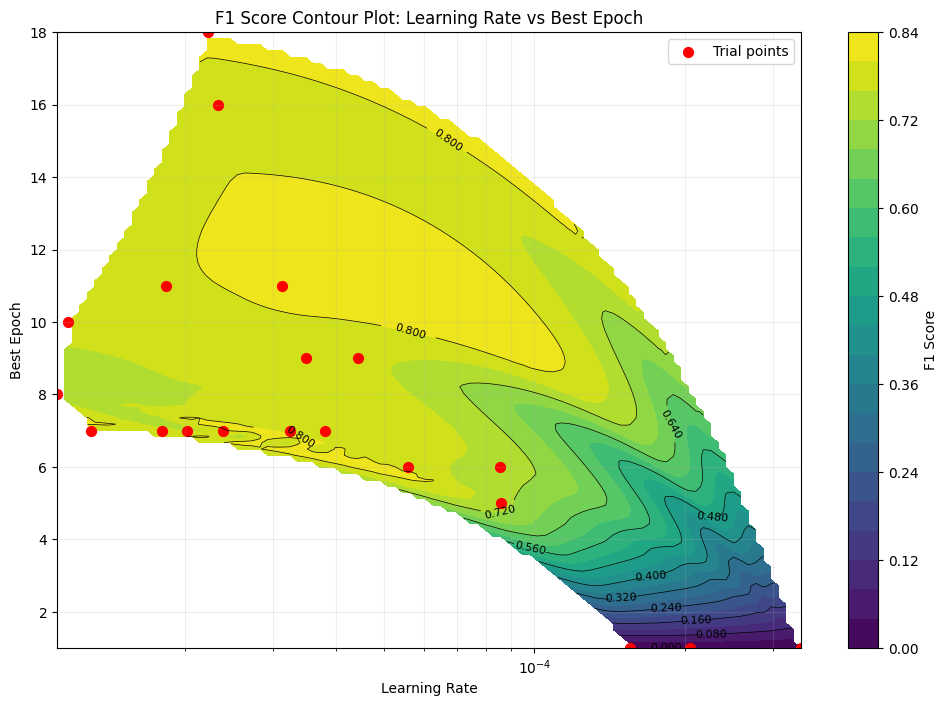

In [16]:
from scipy.interpolate import griddata
def create_contour_plot(best_epochs_data):
    # Extract data for plotting
    epochs = [data['best_epoch'] for data in best_epochs_data.values()]
    learning_rates = [data['learning_rate'] for data in best_epochs_data.values()]
    f1_scores = [data['best_f1'] for data in best_epochs_data.values()]
    
    # Create a regular grid to interpolate the data
    lr_min, lr_max = min(learning_rates), max(learning_rates)
    epoch_min, epoch_max = min(epochs), max(epochs)
    
    # Create grid points
    lr_grid = np.logspace(np.log10(lr_min), np.log10(lr_max), 100)
    epoch_grid = np.linspace(epoch_min, epoch_max, 100)
    LR, EPOCH = np.meshgrid(lr_grid, epoch_grid)
    
    # Interpolate F1 scores on the grid
    points = np.column_stack((learning_rates, epochs))
    F1 = griddata(points, f1_scores, (LR, EPOCH), method='cubic')
    
    # Create the contour plot
    plt.figure(figsize=(12, 8))
    
    # Create filled contour plot
    contour = plt.contourf(LR, EPOCH, F1, levels=20, cmap='viridis')
    
    # Add contour lines with labels
    contour_lines = plt.contour(LR, EPOCH, F1, levels=10, colors='black', linewidths=0.5)
    plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.3f')
    
    # Add scatter points for actual data
    plt.scatter(learning_rates, epochs, c='red', s=50, label='Trial points')
    
    # Add colorbar
    plt.colorbar(contour, label='F1 Score')
    
    # Set axis to logarithmic scale for learning rate
    plt.xscale('log')
    
    # Add labels and title
    plt.xlabel('Learning Rate')
    plt.ylabel('Best Epoch')
    plt.title('F1 Score Contour Plot: Learning Rate vs Best Epoch')
    
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    return plt.gcf()

# Extract best epochs and their metrics
best_epochs_data = find_best_epochs_metrics(hyperparameter_dict)

# Print summary of best epochs and their metrics
print("\nBest epochs summary:")
for trial_num, data in best_epochs_data.items():
    print(f"\nTrial {trial_num}:")
    print(f"Best epoch: {data['best_epoch']}")
    print(f"Learning rate: {data['learning_rate']:.6f}")
    print(f"Best F1 score: {data['best_f1']:.4f}")
    print("Best metrics:", data['best_metrics'])

# Create and show the contour plot
fig = create_contour_plot(best_epochs_data)
plt.show()

# Optionally save the plot
plt.savefig('learning_rate_epoch_contour.png', dpi=300, bbox_inches='tight')
plt.close()

In [33]:
def getf1(example):
    image = example["image"].convert("RGB")
    words = example["tokens"]
    boxes = example["bboxes"]
    normalized_boxes = []

    for i in range(len(boxes)):
        normalized_boxes.append(normalize_box(boxes[i], image.width, image.height))


    normalized_boxes = torch.tensor(normalized_boxes, dtype=torch.long)
    
    word_labels = example["ner_tags"]
    word_labels = torch.tensor(word_labels, dtype=torch.long)

    
    encoding = processor(image, words, boxes=normalized_boxes, word_labels=word_labels,
                         truncation=True, padding="max_length", return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**encoding)
        
    logits = outputs.logits
    predictions = logits.argmax(-1).squeeze().tolist()
    labels = encoding.labels.squeeze().tolist()
    
    true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
    true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]

    correct_predictions = sum(t == p for t, p in zip(true_labels, true_predictions))
    all_tokens = len(true_labels)
    

    return correct_predictions, all_tokens


In [ ]:
correct = 0
all_tokens = 0
for i in range(len(funsd_test_dataset)):
    ci,ai = getf1(funsd_test_dataset[i])
    correct += ci
    all_tokens += ai


In [ ]:
correct/all_tokens

In [ ]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions,true_boxes ):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

In [ ]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(label_map[label]).lower()
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

In [ ]:
### put an image from epant !!!!!!!!!!!!!!!!!!!!!!!!!!!!!